In [252]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [253]:
import numpy as np
import mne
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress, ttest_ind, ttest_rel, ttest_1samp
import pandas as pd
from mne.preprocessing.bads import _find_outliers
import fooof
from fooof import FOOOFGroup
import os 
import joblib
import emd
import statsmodels.formula.api as smf
import statsmodels.api as sm

Note: If you have installed this package in editable form on Minerva, you must append the local path! This is because Minerva requires that you point your package installs away from the local directory for space reasons, but editable packages have to be installed locally.

In [254]:
import sys
sys.path.append('/hpc/users/qasims01/resources/LFPAnalysis')

In [255]:
from LFPAnalysis import lfp_preprocess_utils, sync_utils, analysis_utils, nlx_utils, oscillation_utils

## First, get the behavior data

This is from another notebook with a kernel and environment specifically for beahvior

In [257]:
base_dir = '/sc/arion' # this is the root directory for most un-archived data and results
load_dir = f'{base_dir}/work/qasims01/MemoryBanditData/EMU'
full_data = pd.read_csv(f'{load_dir}/full_df.csv')
learn_df = pd.read_csv(f'{load_dir}/learn_df.csv')
combined_df = pd.read_csv(f'{load_dir}/combined_df.csv')

In [6]:
# Load the demographics data to get information about who has run the task
demo_file = f'{base_dir}/projects/guLab/Salman/EMU/MemoryBanditsDatabase.xlsx'
demo_data = pd.read_excel(demo_file, engine='openpyxl')
subj_df = demo_data[(demo_data.LongVersion==1) & (demo_data.Minerva==1)]

In [7]:
# # Check that the subjects in subj_df are all accounted for in behavior
# subj_df.MSSMCode.values

In [8]:
# Let's get rid of Iowa patients for now 

subj_df = subj_df[subj_df.Site!='UI']

# Let's get rid of the person with no photodiode 

# subj_df = subj_df[subj_df.MSSMCode!='MS022']


## Test out the .ncs code for duplicates

In [136]:
import re

path_to_data = f'{base_dir}/projects/guLab/Salman/EMU/MS003/test/'

pattern = re.compile(r"_\d{4}\.ncs") 
# This is dumb. We should sort them, load the ones that load (some don't have data), and concatenate them all. Once again, stupid.

# First, let's list the files wihout a number attached. This always comes first: 
ncs_files = [x for x in glob(f'{path_to_data}/*.ncs') if re.search(pattern, x)]



In [137]:
ncs_files

['/sc/arion/projects/guLab/Salman/EMU/MS003/test/LAM1_0007.ncs',
 '/sc/arion/projects/guLab/Salman/EMU/MS003/test/LAM1_0005.ncs']

In [133]:

# Second, let's compile a dictionary for each of these, listing out it's duplicates
duplicates_dict = {f'{os.path.split(ncs_files[0])[-1][:-4]}':[ncs_files[0]] for x in ncs_files}

for filename in ncs_files: 
    chan_name = os.path.split(ncs_files[0])[-1][:-4]
    list_concat_chans = [x for x in glob(f'{path_to_data}/*.ncs') if re.search(pattern, x)]
    list_concat_chans = [x for x in list_concat_chans if chan_name in x]
    for duplicate_file in list_concat_chans:
        try:
            test_load = nlx_utils.load_ncs(duplicate_file)
            # If it loads ok, do nothing
        except: 
            # If it fails to load, remove it from the list
            list_concat_chans.remove(duplicate_file)

    duplicates_dict[chan_name]+=list_concat_chans

In [134]:
duplicates_dict

{}

In [138]:
test_load1 = nlx_utils.load_ncs(ncs_files[0])
test_load2 = nlx_utils.load_ncs(ncs_files[1])


In [153]:
test_load1

{'file_path': '/sc/arion/projects/guLab/Salman/EMU/MS003/test/LAM1_0007.ncs',
 'raw_header': b'######## Neuralynx Data File Header\r\n-FileType NCS\r\n-FileVersion 3.4\r\n-FileUUID f3a1693d-1f89-4e25-9af8-0b6b0a673ead\r\n-SessionUUID 0c890e78-dcfb-4649-be9b-bcb0997c5f0c\r\n-ProbeName \r\n-OriginalFileName "D:\\PegasusData\\DA11\\2021-06-18_17-01-21\\LAM1_0007.ncs"\r\n-TimeCreated 2021/06/19 10:04:18\r\n-TimeClosed 2021/06/19 10:38:54\r\n\r\n-RecordSize 1044\r\n-ApplicationName Pegasus "2.2.0 "\r\n-AcquisitionSystem AcqSystem1 ATLAS\r\n-ReferenceChannel "AD Channel 0081"\r\n-SamplingFrequency 4000\r\n-ADMaxValue 32767\r\n-ADBitVolts 0.000000030517578125000001\r\n-AcqEntName LAM1\r\n-NumADChannels 1\r\n-ADChannel 82\r\n-InputRange 1000\r\n-InputInverted True\r\n\r\n-DSPLowCutFilterEnabled True\r\n-DspLowCutFrequency 0.1\r\n-DspLowCutNumTaps 0\r\n-DspLowCutFilterType DCO\r\n-DSPHighCutFilterEnabled True\r\n-DspHighCutFrequency 1000\r\n-DspHighCutNumTaps 256\r\n-DspHighCutFilterType FIR\r\

In [154]:
test_load2

{'file_path': '/sc/arion/projects/guLab/Salman/EMU/MS003/test/LAM1_0005.ncs',
 'raw_header': b'######## Neuralynx Data File Header\r\n-FileType NCS\r\n-FileVersion 3.4\r\n-FileUUID 3c88f4f4-3cc2-4f4e-af74-a24843ed1700\r\n-SessionUUID 0c890e78-dcfb-4649-be9b-bcb0997c5f0c\r\n-ProbeName \r\n-OriginalFileName "D:\\PegasusData\\DA11\\2021-06-18_17-01-21\\LAM1_0005.ncs"\r\n-TimeCreated 2021/06/19 08:57:54\r\n-TimeClosed 2021/06/19 09:14:01\r\n\r\n-RecordSize 1044\r\n-ApplicationName Pegasus "2.2.0 "\r\n-AcquisitionSystem AcqSystem1 ATLAS\r\n-ReferenceChannel "AD Channel 0081"\r\n-SamplingFrequency 4000\r\n-ADMaxValue 32767\r\n-ADBitVolts 0.000000030517578125000001\r\n-AcqEntName LAM1\r\n-NumADChannels 1\r\n-ADChannel 82\r\n-InputRange 1000\r\n-InputInverted True\r\n\r\n-DSPLowCutFilterEnabled True\r\n-DspLowCutFrequency 0.1\r\n-DspLowCutNumTaps 0\r\n-DspLowCutFilterType DCO\r\n-DSPHighCutFilterEnabled True\r\n-DspHighCutFrequency 1000\r\n-DspHighCutNumTaps 256\r\n-DspHighCutFilterType FIR\r\

In [152]:
3529669333/1000000/60

58.82782221666666

## Load, pre-process and re-reference the neural data

Troubleshoot MS022:

In [54]:
# load_path = f'{base_dir}/projects/guLab/Salman/EMU/MS022/neural/Day1'
# # elec_file = f'{base_dir}/projects/guLab/Salman/EMU/MS022/anat/MS022_labels.csv'
# edf_file = glob(f'{load_path}/*.edf')[0]
# mne_data = mne.io.read_raw_edf(edf_file, preload=True)
# # Sanity check the photodiode
# trig_ix = mne_data.ch_names.index('DC1')
# plt.plot(mne_data._data[trig_ix])
# plt.title("Photodiode")
# plt.show()

In [19]:
days = ['Day1', 'Day2']
subj_ids = subj_df.MSSMCode.values
subj_formats = subj_df.format.values
subj_sites = subj_df.Site.values
subj_days = subj_df.Day2.values

Run the initial loading and 

In [78]:

for ix, subj_id in enumerate(subj_ids[-2:-1]): 
    site = subj_sites[-2:-1][ix]
    format = subj_formats[-2:-1][ix]
    for day in days:
        # Check if this day is in the dataset:
        if subj_df[subj_df.MSSMCode==subj_id][day].values[0] == 0:
            print (f'subject {subj_id} does not have Day 2 data')
            continue
        else:
            print(f'Working on subj {subj_id}')
            # Set paths
            load_path = f'{base_dir}/projects/guLab/Salman/EMU/{subj_id}/neural/{day}'
            elec_path = f'{base_dir}/projects/guLab/Salman/EMU/{subj_id}/anat/'
            save_path = f'{base_dir}/work/qasims01/MemoryBanditData/EMU/Subjects/{subj_id}/neural/{day}'
            # Check if path exists for saving, and if not, make it
            if not os.path.exists(save_path):
                os.makedirs(save_path)

            # electrode files could either be csv or excel
            elec_files = glob(f'{elec_path}/*.csv') + glob(f'{elec_path}/*.xlsx')
            # There should really only be one, so grab it with the zero-index 
            elec_file = elec_files[0]

            # Make MNE file
            mne_data = lfp_preprocess_utils.make_mne(load_path=load_path, 
                                                     elec_path=elec_file, 
                                                     format=format,
                                                     return_data=True,
                                                     site=site)
            
            # Save this data so that you don't need this step again:
            mne_data.save(f'{save_path}/raw_ieeg.fif', overwrite=True)


Working on subj MS026


/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/lfp_preprocess_utils.py:986: UserWarning: No sync name specified - if using an audiovisual sync signal please check load_path to make sure a valid sync was saved out
  warnings.warn(f'No sync name specified - if using an audiovisual sync signal please check load_path to make sure a valid sync was saved out')
/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/nlx_utils.py:156: UserWarning: Invalid samples in one or more records
  warnings.warn('Invalid samples in one or more records')
/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/nlx_utils.py:183: UserWarning: Unable to rescale data, no ADBitVolts value specified in header
  warnings.warn('Unable to rescale data, no ADBitVolts value specified in header')


Data in numbered files
Unidentified data type in BLANK2
Unidentified data type in CHEST1
Unidentified data type in ABS2
Unidentified data type in ABS1
Unidentified data type in Mic
Unidentified data type in Audio
Unidentified data type in Photodiode
Unidentified data type in BLANK1
Unidentified data type in EKG1
Unidentified data type in Analog5
Unidentified data type in CHEST2
Unidentified data type in EKG2
Unidentified data type in Photo
Unidentified data type in Analog6


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   53.9s
[Parallel(n_jobs=-1)]: Done  31 out of  31 | elapsed:  2.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 187 out of 187 | elapsed:   23.2s finished


Saving photodiode data to /sc/arion/projects/guLab/Salman/EMU/MS026/neural/Day1/photodiode.fif
Saving EEG data to /sc/arion/projects/guLab/Salman/EMU/MS026/neural/Day1/scalp_eeg_data.fif


/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/lfp_preprocess_utils.py:1174: RuntimeWarning: This filename (/sc/arion/projects/guLab/Salman/EMU/MS026/neural/Day1/photodiode.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  mne_data.save(f'{load_path}/photodiode.fif', picks=sync_name, overwrite=overwrite)
/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/lfp_preprocess_utils.py:1191: RuntimeWarning: This filename (/sc/arion/projects/guLab/Salman/EMU/MS026/neural/Day1/scalp_eeg_data.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  mne_data.save(f'{load_path}/scalp_eeg_data.fif', picks=eeg_names, overwrite=overwrite

Saving LFP data to /sc/arion/projects/guLab/Salman/EMU/MS026/neural/Day1/lfp_data.fif


/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/lfp_preprocess_utils.py:1217: RuntimeWarning: This filename (/sc/arion/projects/guLab/Salman/EMU/MS026/neural/Day1/lfp_data.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  mne_data.save(f'{load_path}/lfp_data.fif', picks=seeg_names, overwrite=overwrite)


Working on subj MS026


/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/lfp_preprocess_utils.py:986: UserWarning: No sync name specified - if using an audiovisual sync signal please check load_path to make sure a valid sync was saved out
  warnings.warn(f'No sync name specified - if using an audiovisual sync signal please check load_path to make sure a valid sync was saved out')
/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/nlx_utils.py:156: UserWarning: Invalid samples in one or more records
  warnings.warn('Invalid samples in one or more records')
/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/nlx_utils.py:183: UserWarning: Unable to rescale data, no ADBitVolts value specified in header
  warnings.warn('Unable to rescale data, no ADBitVolts value specified in header')


Data in numbered files
Unidentified data type in EKG2
Unidentified data type in Mic
Unidentified data type in Photodiode
Unidentified data type in CHEST1
Unidentified data type in BLANK2
Unidentified data type in Analog5
Unidentified data type in EKG1
Unidentified data type in ABS2
Unidentified data type in Analog6
Unidentified data type in BLANK1
Unidentified data type in CHEST2
Unidentified data type in Photo
Unidentified data type in Audio
Unidentified data type in ABS1


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   35.9s
[Parallel(n_jobs=-1)]: Done  31 out of  31 | elapsed:  1.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 187 out of 187 | elapsed:   16.1s finished


Saving photodiode data to /sc/arion/projects/guLab/Salman/EMU/MS026/neural/Day2/photodiode.fif
Saving EEG data to /sc/arion/projects/guLab/Salman/EMU/MS026/neural/Day2/scalp_eeg_data.fif


/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/lfp_preprocess_utils.py:1174: RuntimeWarning: This filename (/sc/arion/projects/guLab/Salman/EMU/MS026/neural/Day2/photodiode.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  mne_data.save(f'{load_path}/photodiode.fif', picks=sync_name, overwrite=overwrite)
/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/lfp_preprocess_utils.py:1191: RuntimeWarning: This filename (/sc/arion/projects/guLab/Salman/EMU/MS026/neural/Day2/scalp_eeg_data.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  mne_data.save(f'{load_path}/scalp_eeg_data.fif', picks=eeg_names, overwrite=overwrite

Saving LFP data to /sc/arion/projects/guLab/Salman/EMU/MS026/neural/Day2/lfp_data.fif


/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/lfp_preprocess_utils.py:1217: RuntimeWarning: This filename (/sc/arion/projects/guLab/Salman/EMU/MS026/neural/Day2/lfp_data.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  mne_data.save(f'{load_path}/lfp_data.fif', picks=seeg_names, overwrite=overwrite)


Manually annotate bad channels for each recording: 

In [21]:
subj_df

Site MSSMCode  OtherCodes  Day1  Day2  LongVersion      Date1  \
3   MSSM    MS012         NaN     1     0            1 2022-08-10   
5   MSSM    MS015         NaN     1     1            1 2022-09-24   
6   MSSM    MS016         NaN     1     1            1 2022-09-24   
7   MSSM    MS017         NaN     1     1            1 2022-10-05   
9   MSSM    MS019         NaN     1     1            1 2022-12-01   
10  MSSM    MS020         NaN     1     1            1 2023-02-02   
11  MSSM    MS022         NaN     1     0            1 2023-02-05   
12  MSSM    MS023         NaN     1     1            1 2023-02-21   
14  MSSM    MS024         NaN     1     1            1 2023-03-01   
15  MSSM    MS025         NaN     1     1            1 2023-03-09   
16  MSSM    MS026         NaN     1     1            1 2023-03-23   
17  MSSM    MS028         NaN     1     0            1 2023-04-05   

          Experimenter  Micros  Resp  ... Minerva   Age   BDI   BAI  IQ  \
3              Lizbeth     0.0   0.0  ...       1  20.0   NaN   NaN NaN   
5     Salman + Lizbeth     0.0   0.0  ...       1  33.0   8.0   0.0 NaN   
6     Salman + Lizbeth     0.0   0.0  ...       1  24.0   1.0   0.0 NaN   
7     Salman + Lizbeth     0.0   0.0  ...       1  26.0  22.0  29.0 NaN   
9              Lizbeth     0.0   0.0  ...       1  56.0  23.0  13.0 NaN   
10             Lizbeth     1.0   0.0  ...       1  31.0  24.0  14.0 NaN   
11    Lizbeth + Jackie     1.0   0.0  ...       1  65.0  10.0  12.0 NaN   
12             Lizbeth     0.0   0.0  ...       1  52.0   6.0   4.0 NaN   
14             Lizbeth     1.0   0.0  ...       1  32.0   NaN   NaN NaN   
15  Christina + Jackie     1.0   0.0  ...       1  38.0   3.0  10.0 NaN   
16              Salman     1.0   1.0  ...       1  49.0  18.0  30.0 NaN   
17             Lizbeth     1.0   NaN  ...       1  32.0   2.0  12.0 NaN   

    Education  Handedness  Sex              Race       Ethnicity  
3         NaN           R   F              White    Not Hispanic  
5         NaN           R    F  African-American    Not Hispanic  
6         NaN           R    F               NaN        Hispanic  
7         NaN           R    F             Other  Latin-American  
9         NaN           R    M             White             NaN  
10        NaN           R    F               NaN             NaN  
11        NaN           R    M               NaN             NaN  
12        NaN         NaN    M               NaN             NaN  
14        NaN         NaN    M  African-American    Not Hispanic  
15        NaN         NaN    F             White    Not Hispanic  
16        NaN         NaN    F            White     Puerto Rican  
17        NaN         NaN    F  African-American    Not Hispanic  

[12 rows x 25 columns]

In [88]:
%matplotlib notebook

<IPython.core.display.Javascript object>


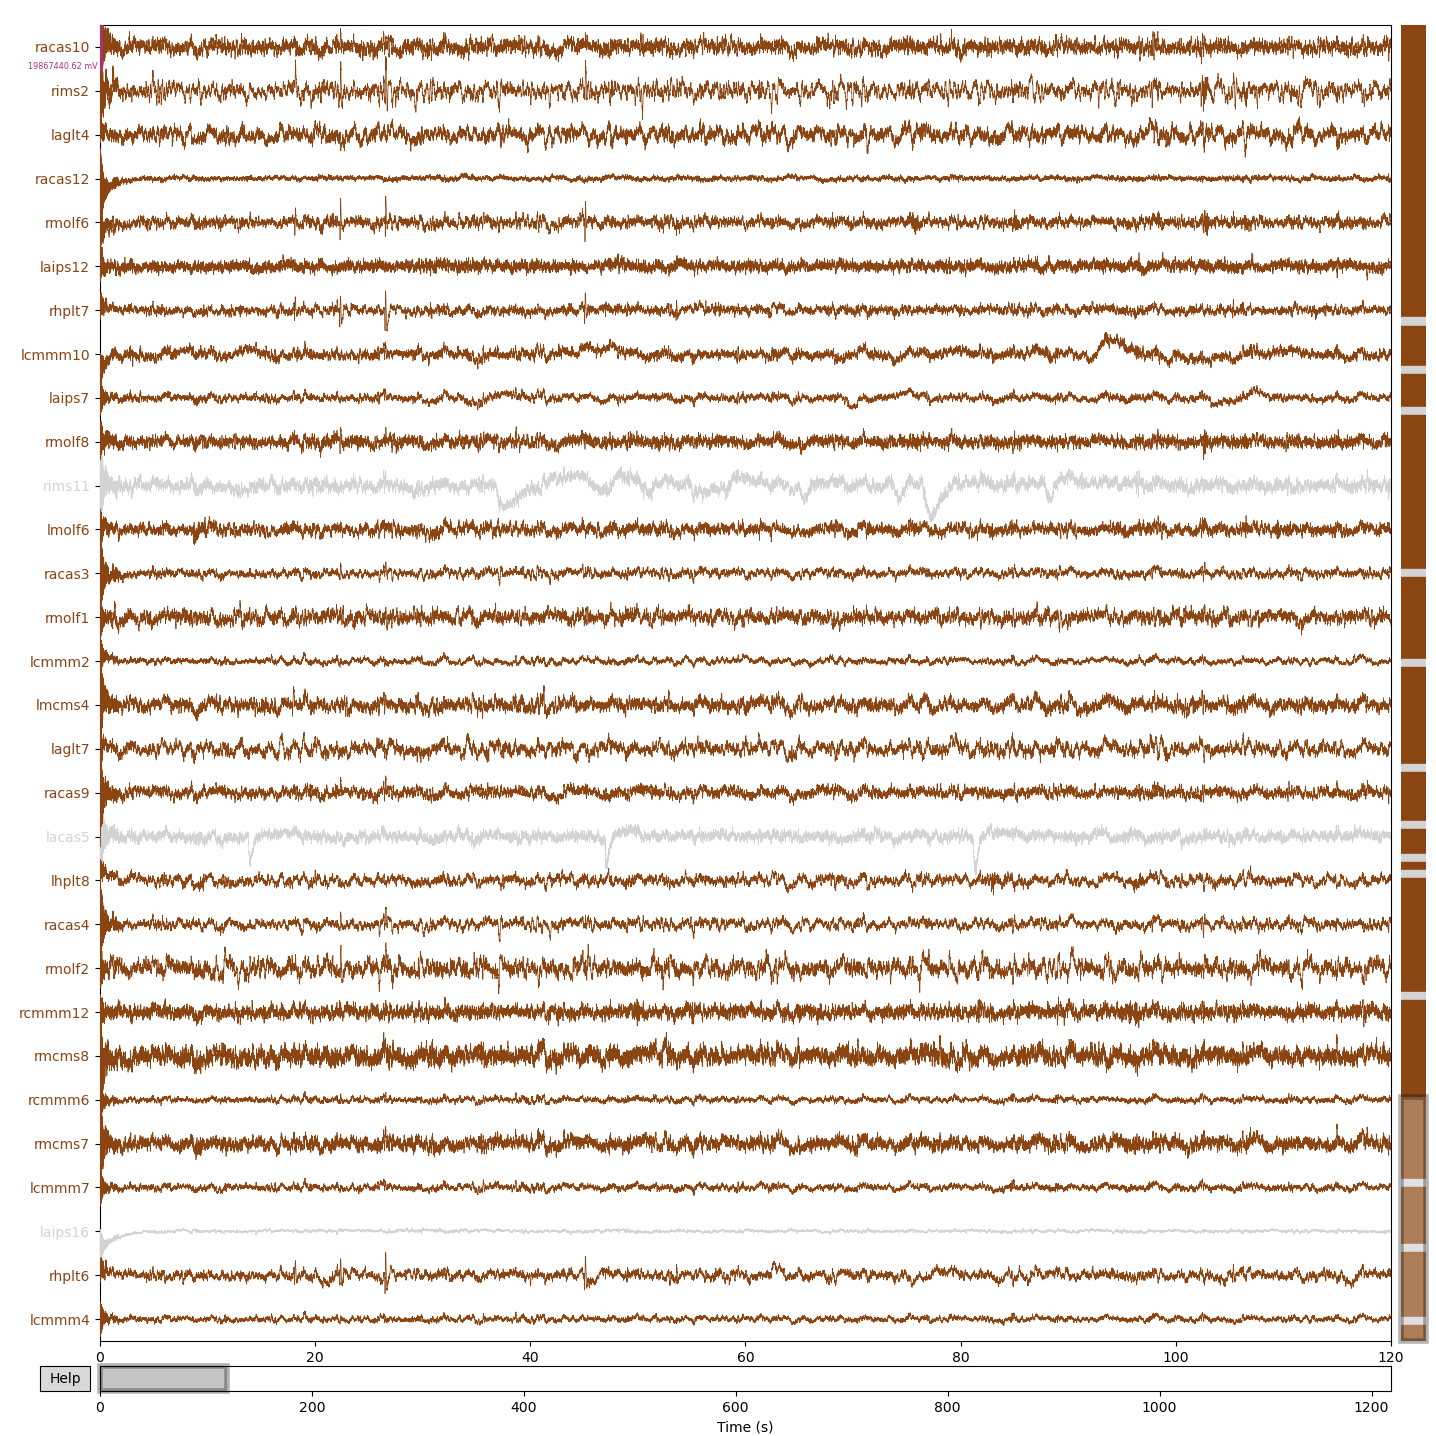

In [94]:
subj_id = 'MS028'
day = 'Day1'
save_path = f'{base_dir}/work/qasims01/MemoryBanditData/EMU/Subjects/{subj_id}/neural/{day}'
mne_data = mne.io.read_raw_fif(f'{save_path}/raw_ieeg.fif', preload=True)
fig = mne_data.plot(start=0, duration=120, n_channels=30, 
                      scalings=mne_data._data.max()/5
                     )

In [95]:
# Save this manual data
mne_data.save(f'{save_path}/raw_ieeg.fif', overwrite=True)

Test out the Bipolar reference

In [157]:
for ix, subj_id in enumerate(subj_ids): 
    site = subj_sites[ix]
    format = subj_formats[ix]
    for day in days:
        # Check if this day is in the dataset:
        if subj_df[day].values[ix] == 0:
            print (f'subject {subj_id} does not have Day 2 data')
            continue
        else:
            print(f'Working on subj {subj_id}')
            # Set paths
            load_path = f'{base_dir}/projects/guLab/Salman/EMU/{subj_id}/neural/{day}'
            elec_path = f'{base_dir}/projects/guLab/Salman/EMU/{subj_id}/anat/'
            save_path = f'{base_dir}/work/qasims01/MemoryBanditData/EMU/Subjects/{subj_id}/neural/{day}'
            # Check if path exists for saving, and if not, make it
            if not os.path.exists(save_path):
                os.makedirs(save_path)

            # electrode files could either be csv or excel
            elec_files = glob(f'{elec_path}/*.csv') + glob(f'{elec_path}/*.xlsx')
            # There should really only be one, so grab it with the zero-index 
            elec_file = elec_files[0]

            # Make MNE file
            mne_data = mne.io.read_raw_fif(f'{save_path}/raw_ieeg.fif', preload=True)


            # Re-reference neural data
            mne_data_reref = lfp_preprocess_utils.ref_mne(mne_data=mne_data, 
                                                          elec_path=elec_file, 
                                                          method='bipolar', 
                                                          site=site)

            # Save this data so that you don't need this step again:
            mne_data_reref.save(f'{save_path}/bp_ref_ieeg.fif', overwrite=True)


Working on subj MS012
subject MS012 does not have Day 2 data
Working on subj MS015
Working on subj MS015
Working on subj MS016
Number of electrodes in the mne file is less than the number of electrodes in the localization file
Working on subj MS016
Number of electrodes in the mne file is less than the number of electrodes in the localization file
Working on subj MS017
Number of electrodes in the mne file is less than the number of electrodes in the localization file
Working on subj MS017
Number of electrodes in the mne file is less than the number of electrodes in the localization file
Working on subj MS019
Number of electrodes in the mne file is less than the number of electrodes in the localization file
Working on subj MS019
Number of electrodes in the mne file is less than the number of electrodes in the localization file
Working on subj MS020
Number of electrodes in the mne file is less than the number of electrodes in the localization file
Working on subj MS020
Number of electrode

<IPython.core.display.Javascript object>


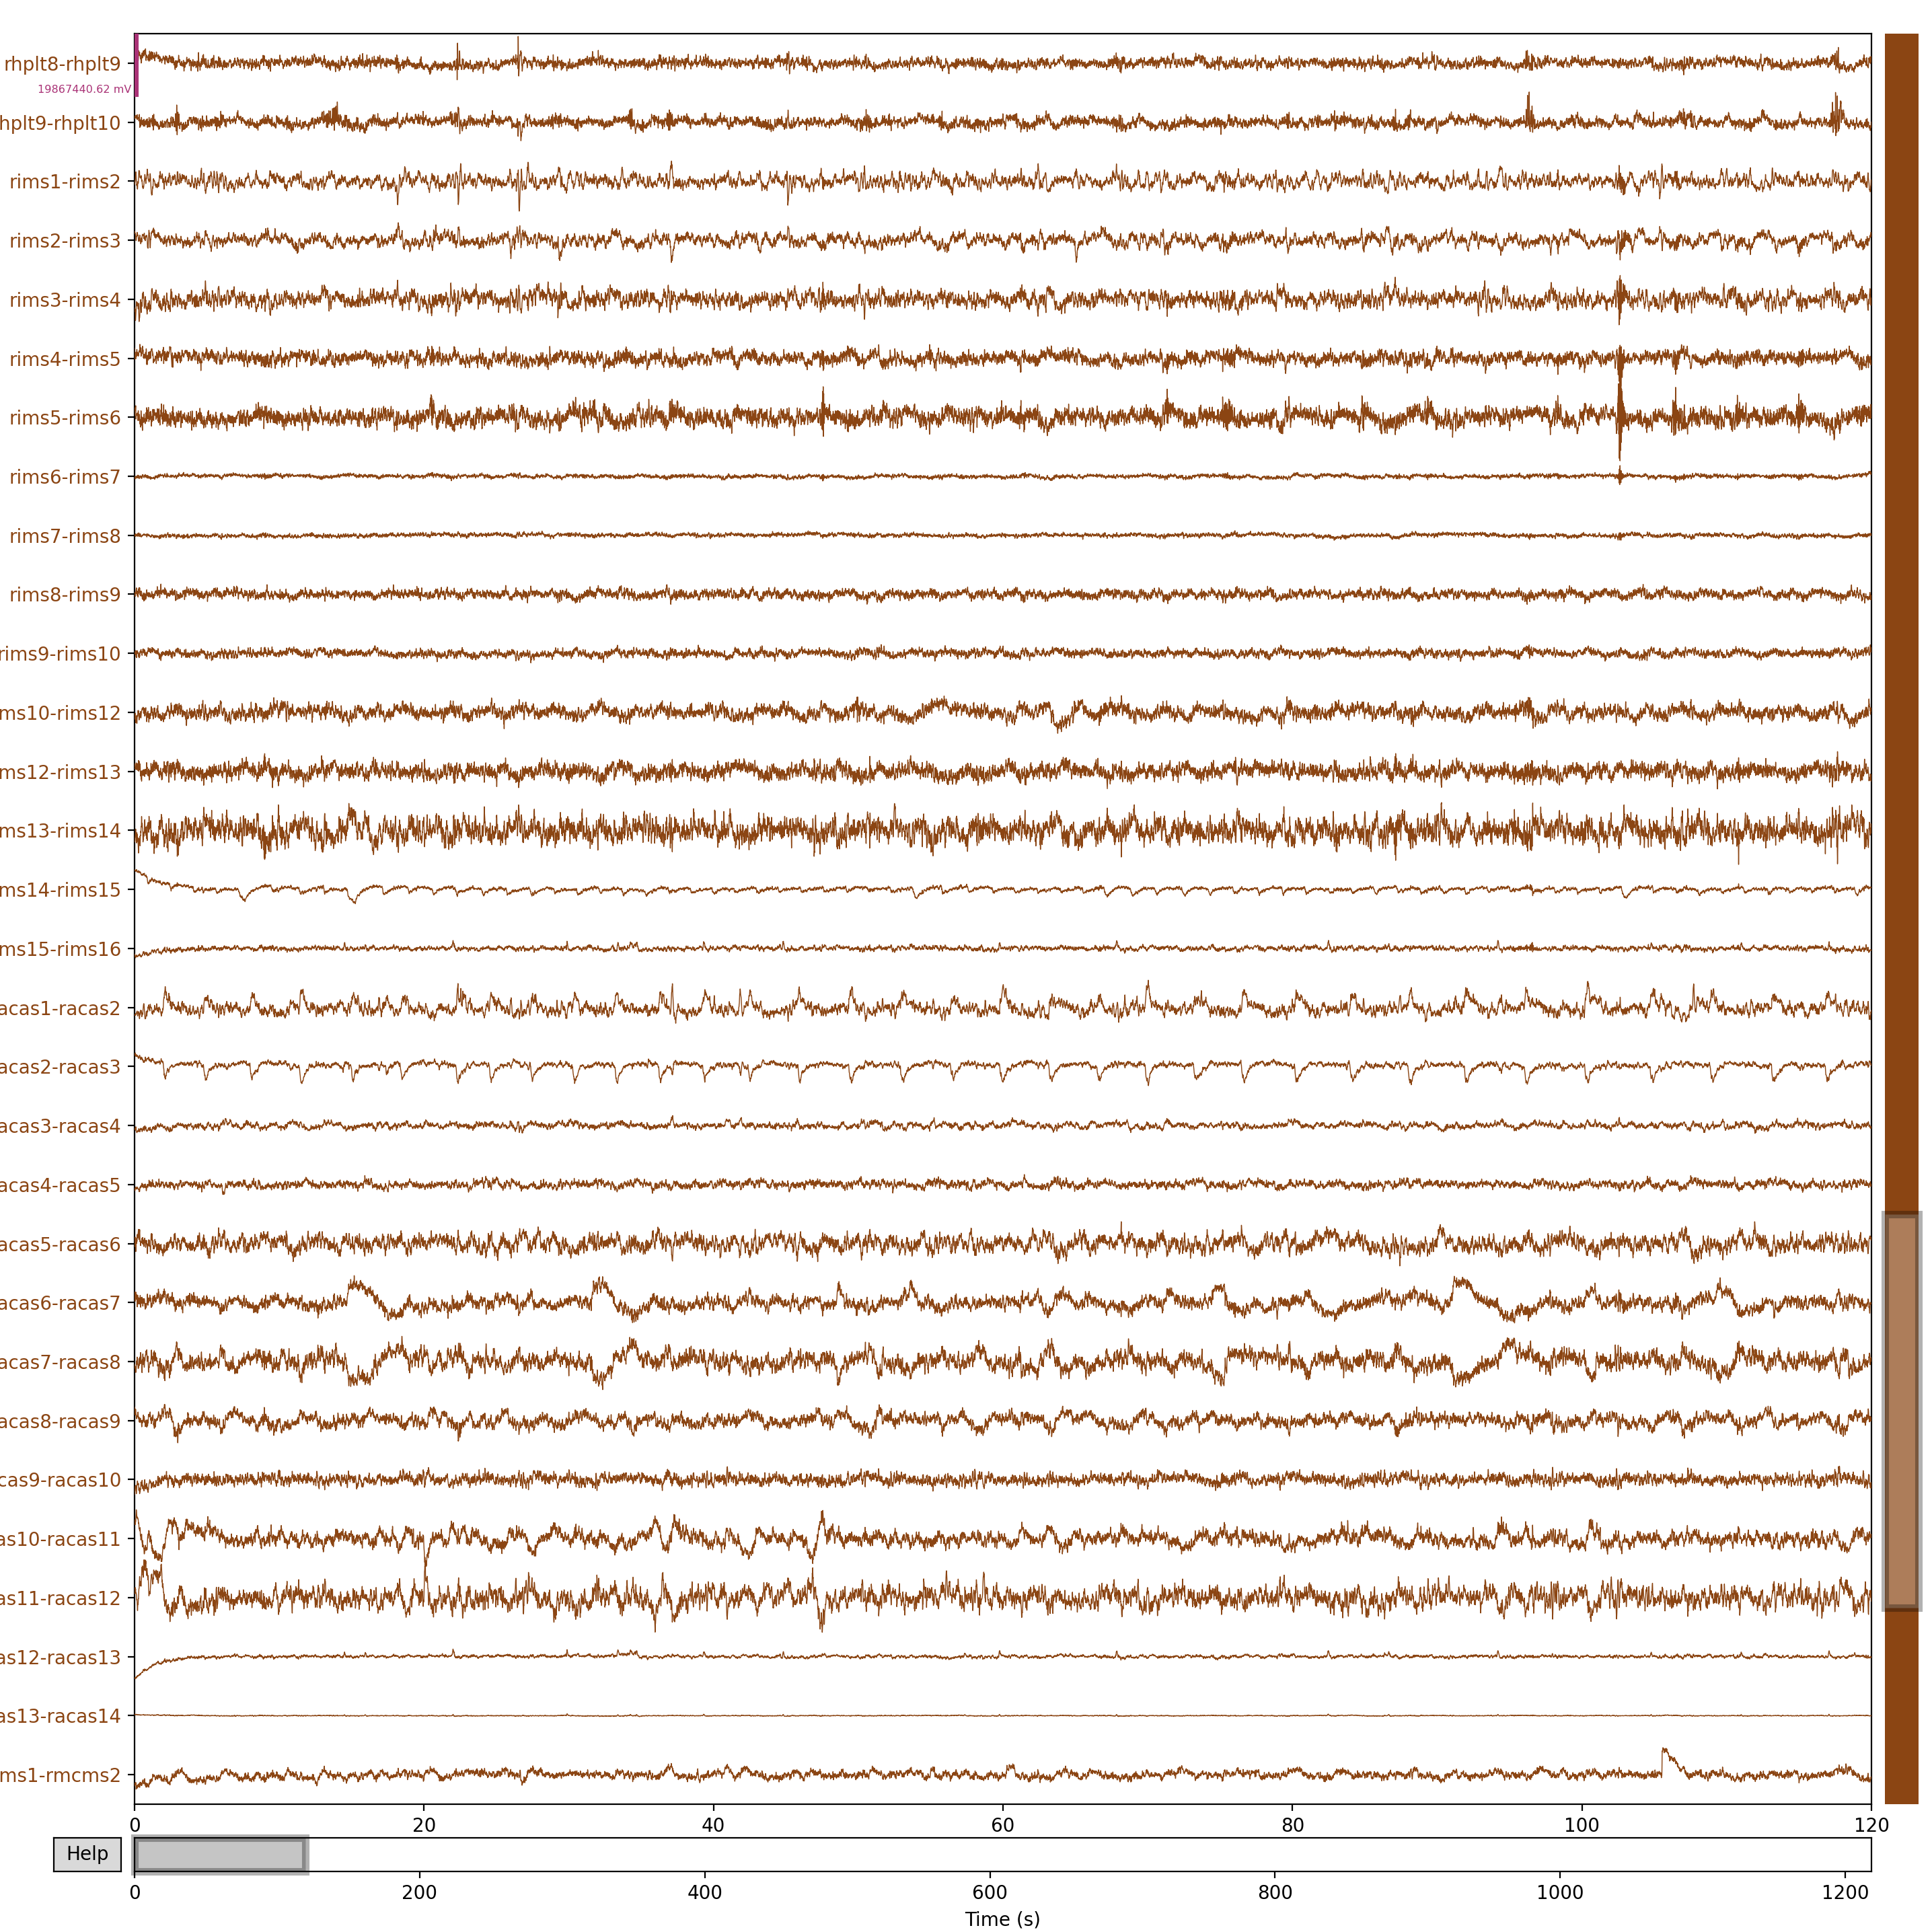

In [159]:
fig = mne_data_reref.plot(start=0, duration=120, n_channels=30, 
                      scalings=mne_data._data.max()/5, lowpass=40
                     )

 - mne_data: a Raw mne object, where the data has been loaded, filtered for line noise, searched for bad channels, parsed for different data types, and resampled if necessary. 
 
 - mne_data_reref: an mne object containing re-referenced data (either white matter or bipolar)

If you have ran the preprocessing above, load the data instead: 

In [175]:
%matplotlib inline

In [161]:
elec_dict = {f'{x}': {f'{y}': [] for y in days} for x in subj_ids}
mne_dict = {f'{x}': {f'{y}': [] for y in days} for x in subj_ids}
photodiode_dict = {f'{x}': {f'{y}': [] for y in days} for x in subj_ids}

In [162]:
for ix, subj_id in enumerate(subj_ids): 
    for day in days:
        # Check if this day is in the dataset:
        if subj_df[day].values[ix] == 0:
            print (f'subject {subj_id} does not have Day 2 data')
            continue
        else:
            # Set paths
            load_path = f'{base_dir}/projects/guLab/Salman/EMU/{subj_id}/neural/{day}'
            elec_path = f'{base_dir}/projects/guLab/Salman/EMU/{subj_id}/anat/'
            save_path = f'{base_dir}/work/qasims01/MemoryBanditData/EMU/Subjects/{subj_id}/neural/{day}'

            elec_files = glob(f'{elec_path}/*.csv') + glob(f'{elec_path}/*.xlsx')
            # There should really only be one 
            elec_file = elec_files[0]
            elec_data = lfp_preprocess_utils.load_elec(elec_file)

            mne_data_reref = mne.io.read_raw_fif(f'{save_path}/bp_ref_ieeg.fif', preload=True)

            photodiode_data = mne.io.read_raw_fif(f'{load_path}/photodiode.fif', preload=True)

            # Append to list 
            mne_dict[subj_id][day].append(mne_data_reref)

            photodiode_dict[subj_id][day].append(photodiode_data)

            elec_dict[subj_id][day].append(elec_file)

/tmp/ipykernel_93208/166778422.py:20: RuntimeWarning: This filename (/sc/arion/projects/guLab/Salman/EMU/MS012/neural/Day1/photodiode.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  photodiode_data = mne.io.read_raw_fif(f'{load_path}/photodiode.fif', preload=True)


subject MS012 does not have Day 2 data


/tmp/ipykernel_93208/166778422.py:20: RuntimeWarning: This filename (/sc/arion/projects/guLab/Salman/EMU/MS015/neural/Day1/photodiode.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  photodiode_data = mne.io.read_raw_fif(f'{load_path}/photodiode.fif', preload=True)
/tmp/ipykernel_93208/166778422.py:20: RuntimeWarning: This filename (/sc/arion/projects/guLab/Salman/EMU/MS015/neural/Day2/photodiode.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  photodiode_data = mne.io.read_raw_fif(f'{load_path}/photodiode.fif', preload=True)
/tmp/ipykernel_93208/166778422.py:20: RuntimeWarning: This filename (/sc/arion/projects/guLab/Salm

subject MS022 does not have Day 2 data


/tmp/ipykernel_93208/166778422.py:20: RuntimeWarning: This filename (/sc/arion/projects/guLab/Salman/EMU/MS023/neural/Day1/photodiode.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  photodiode_data = mne.io.read_raw_fif(f'{load_path}/photodiode.fif', preload=True)
/tmp/ipykernel_93208/166778422.py:20: RuntimeWarning: This filename (/sc/arion/projects/guLab/Salman/EMU/MS023/neural/Day2/photodiode.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  photodiode_data = mne.io.read_raw_fif(f'{load_path}/photodiode.fif', preload=True)
/tmp/ipykernel_93208/166778422.py:20: RuntimeWarning: This filename (/sc/arion/projects/guLab/Salm

subject MS028 does not have Day 2 data



 - mne_dict: a dictionary containing all of your subjects' re-referenced mne data 
 
 - photodiode_dict: a dictionary containing all of your subjects' photodiode data 
 
 - elec_dict: a dictionary containing the paths to your subjects' electrode data 

## Sync behavioral and neural data



Here, we perform a critical step: computing the time offset between the computer that recorded the neural data and the laptop that featured the experiment. 

The function here only requires a **subset** of detected sync signals (i.e. photodiode deflections) to be detected to successfully compute this offset. 


First, some of the photodiode data can be a bit crummy, which you need to clean up in an idiosyncratic way... ugh

In [164]:
subj_id = 'MS022'
day = 'Day1'
temp_diode = np.abs(photodiode_dict[subj_id][day][0]._data[0,:])
temp_diode[temp_diode>.13] = 0.1
photodiode_dict[subj_id][day][0]._data = temp_diode

subj_id = 'MS026'
day = 'Day1'
temp_diode = photodiode_dict[subj_id][day][0]._data[0,:]
temp_diode[temp_diode>4000] = 0
photodiode_dict[subj_id][day][0]._data = temp_diode

subj_id = 'MS028'
day = 'Day1'
temp_diode = photodiode_dict[subj_id][day][0]._data[0,:]
temp_diode[temp_diode>4000] = 0
temp_diode[temp_diode<-3000] = 0
photodiode_dict[subj_id][day][0]._data = temp_diode

Now, let's compute the slopes and offsets

In [168]:
slopes = {f'{x}': {f'{y}': [] for y in days} for x in subj_ids}
offsets = {f'{x}': {f'{y}': [] for y in days} for x in subj_ids}


for ix, subj_id in enumerate(subj_ids): 
    for day in days:
        # Check if this day is in the dataset:
        if subj_df[day].values[ix] == 0:
            print (f'subject {subj_id} does not have Day 2 data')
            continue
        else:
            print(f'Working on subj {subj_id}')
            # Load the behavioral timestamps: 
            behav_path = f'{base_dir}/projects/guLab/Salman/EMU/{subj_id}/behav/{day}'
            temp_df = pd.read_csv(glob(f'{behav_path}/*.csv')[0], index_col=None, header=0)
            # Load in the timestamps pertaining to your sync. If your task had a square pop up, for example, grab the times for that square's appearance from the behavioral logs.
            # Below, I do this for my own task's Psychopy output, but yours is probably coded differently. 
            beh_ts = temp_df[temp_df.keys()[temp_df.keys().str.startswith('sync') & temp_df.keys().str.endswith('started')]].values
            beh_ts = beh_ts[~np.isnan(beh_ts)] 

            # Synchronize to the photodiode or whatever your neural sync signal is
            height = 1
            if subj_id in ['MS020']:
                if day == 'Day1':
                    height = 1.5
#             elif subj_id in ['MS022', 'MS025', 'MS026']:
#                 if day == 'Day1':
#                     height = 2
#             elif subj_id in ['MS028']:
#                 if day == 'Day1':
#                     height = 0.5            
            slope, offset = sync_utils.synchronize_data(beh_ts, 
                                                        photodiode_dict[subj_id][day][0], 
                                                        smoothSize=11, windSize=15, height=height)

            slopes[subj_id][day].append(slope)
            offsets[subj_id][day].append(offset)

Working on subj MS012
28 blocks
............................

found matches for 150 of 428 pulses
21 blocks
.....................

found matches for 120 of 428 pulses
17 blocks
.................

found matches for 125 of 428 pulses
14 blocks
..............

found matches for 120 of 428 pulses
subject MS012 does not have Day 2 data
Working on subj MS015
31 blocks
...............................

found matches for 270 of 465 pulses
23 blocks
.......................

found matches for 220 of 465 pulses
18 blocks
..................

found matches for 225 of 465 pulses
Working on subj MS015
10 blocks
..........

found matches for 150 of 160 pulses
Working on subj MS016
28 blocks
............................

found matches for 315 of 426 pulses
21 blocks
.....................

found matches for 320 of 426 pulses
17 blocks
.................

found matches for 200 of 426 pulses
Working on subj MS016
9 blocks
.........

found matches for 75 of 139 pulses
6 blocks
......

found matches for 60 of

/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/sync_utils.py:169: UserWarning: Your height parameter may be too strict - consider setting it a little lower
  warnings.warn("Your height parameter may be too strict - consider setting it a little lower")


..........

found matches for 60 of 165 pulses
8 blocks
........

found matches for 40 of 165 pulses
6 blocks
......

found matches for 25 of 165 pulses
Working on subj MS019
10 blocks
..........

found matches for 135 of 164 pulses
8 blocks
........

found matches for 140 of 164 pulses
6 blocks
......

found matches for 125 of 164 pulses
Working on subj MS020
117 blocks
.

/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/sync_utils.py:172: UserWarning: Your height parameter may be too lenient - consider setting it a little higher
  warnings.warn("Your height parameter may be too lenient - consider setting it a little higher")


...............................................................................................

/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/sync_utils.py:58: RuntimeWarning: invalid value encountered in double_scalars
  r = c[0, 1] / (np.std(x) * np.std(y))


.....................

found matches for 180 of 1760 pulses
88 blocks
........................................................................................

found matches for 60 of 1760 pulses
Working on subj MS020
10 blocks
..........

found matches for 120 of 162 pulses
Working on subj MS022


/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/sync_utils.py:172: UserWarning: Your height parameter may be too lenient - consider setting it a little higher
  warnings.warn("Your height parameter may be too lenient - consider setting it a little higher")


65 blocks
.................................................................

found matches for 255 of 986 pulses
49 blocks
.................................................

found matches for 140 of 986 pulses
39 blocks
.......................................

found matches for 125 of 986 pulses
32 blocks
................................

found matches for 30 of 986 pulses
subject MS022 does not have Day 2 data
Working on subj MS023
30 blocks
..............................

found matches for 240 of 464 pulses
Working on subj MS023
37 blocks
.....

/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/sync_utils.py:172: UserWarning: Your height parameter may be too lenient - consider setting it a little higher
  warnings.warn("Your height parameter may be too lenient - consider setting it a little higher")


................................

found matches for 150 of 562 pulses
Working on subj MS024
40 blocks
...

/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/sync_utils.py:172: UserWarning: Your height parameter may be too lenient - consider setting it a little higher
  warnings.warn("Your height parameter may be too lenient - consider setting it a little higher")


.....................................

found matches for 75 of 612 pulses
30 blocks
..............................

found matches for 80 of 612 pulses
24 blocks
........................

found matches for 50 of 612 pulses
Working on subj MS024
Working on subj MS025
31 blocks
...............................

found matches for 270 of 469 pulses
23 blocks
.......................

found matches for 200 of 469 pulses
18 blocks
..................

found matches for 200 of 469 pulses
Working on subj MS025


/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/sync_utils.py:172: UserWarning: Your height parameter may be too lenient - consider setting it a little higher
  warnings.warn("Your height parameter may be too lenient - consider setting it a little higher")


77 blocks
.............................................................................

found matches for 45 of 1159 pulses
57 blocks
.........................................................

found matches for 20 of 1159 pulses
Working on subj MS026


/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/sync_utils.py:172: UserWarning: Your height parameter may be too lenient - consider setting it a little higher
  warnings.warn("Your height parameter may be too lenient - consider setting it a little higher")


345 blocks
.........................................................................................................................................................................................................................................................................................................................................................

found matches for 810 of 5186 pulses
259 blocks
...................................................................................................................................................................................................................................................................

found matches for 540 of 5186 pulses
207 blocks
...............................................................................................................................................................................................................

found matches for 325 of 5186 pulses
172 blocks
............................

/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/sync_utils.py:172: UserWarning: Your height parameter may be too lenient - consider setting it a little higher
  warnings.warn("Your height parameter may be too lenient - consider setting it a little higher")


...............................................................................................................................................................

found matches for 165 of 2414 pulses
120 blocks
........................................................................................................................

found matches for 100 of 2414 pulses
96 blocks
................................................................................................

found matches for 75 of 2414 pulses
80 blocks
................................................................................

found matches for 30 of 2414 pulses
subject MS028 does not have Day 2 data



 - slopes: a dictionary containing the slopes (should be ~ 1) for each subject
 - offsets: a dictionary containing the offsets for each subject

## Load your behavioral data

You probably have a separate notebook for processing the behavioral data for your task. Load the processed dataframe here:



In [170]:
behav_data = pd.read_csv(f'{base_dir}/work/qasims01/MemoryBanditData/EMU/learn_df.csv')

# Filter just to the participants in this notebook
behav_data = behav_data[behav_data.participant.isin(subj_ids)]

behav_data.head(5)[['participant', 'feedback_start', 'baseline_start']]

participant  feedback_start  baseline_start
0       MS012      243.239158      244.929025
1       MS012      248.344187      250.043187
2       MS012      254.083059      255.790670
3       MS012      258.148220      259.838892
4       MS012      261.943712      263.620631

In [239]:
behav_data

gamble  gamble_start  gamble_rt  \
0          0    234.674028   7.453226   
1          0    245.496340   1.742425   
2          1    251.043874   1.935539   
3          0    256.591595   0.449431   
4          0    260.439445   0.391258   
...      ...           ...        ...   
1195       0    456.611721   0.441094   
1196       1    460.576551   0.389802   
1197       1    464.541416   0.569781   
1198       1    468.706332   0.669428   
1199       1    473.004290   0.937272   

                                      img_path  prob  block gamble_label  \
0        Google_1_Alberta Davenport_7_oval.png   1.0    1.0         male   
1        Google_1_Leah Hershberger_13_oval.png   0.0    1.0         male   
2     Google_1_Michele Friedman_3_oval (2).png   0.0    1.0       female   
3            Google_1_Deanna Collin_5_oval.png   1.0    1.0         male   
4        Google_1_Lawrence Edwards_15_oval.png   0.0    1.0         male   
...                                        ...   ...    ...          ...   
1195           Google_1_Alan Epley_12_oval.png   0.0    5.0         male   
1196            Google_1_Wendy Mori_3_oval.png   0.0    5.0       female   
1197     Google_1_Eileen Hackworth_17_oval.png   0.0    5.0       female   
1198           Google_1_Lucy Neese_19_oval.png   1.0    5.0       female   
1199        Google_1_Pamela Metzler_9_oval.png   0.0    5.0       female   

      reward participant  feedback_start  baseline_start  trials    DPRIME  \
0        1.0       MS012      243.239158      244.929025       1  2.337818   
1        0.0       MS012      248.344187      250.043187       2  2.211126   
2        0.0       MS012      254.083059      255.790670       3  2.127779   
3        1.0       MS012      258.148220      259.838892       4  1.736366   
4        0.0       MS012      261.943712      263.620631       5  1.975903   
...      ...         ...             ...             ...     ...       ...   
1195     0.0       MS028      458.133465      459.843157      76  3.306850   
1196     0.0       MS028      462.029395      463.758050      77  2.641212   
1197     0.0       MS028      466.180243      467.906247      78  1.879477   
1198     1.0       MS028      470.449625      472.170948      79  2.857570   
1199     0.0       MS028      475.008228      476.735541      80  1.754535   

      good_dm_performance  male  female     alpha      beta       rpe  
0                    True     1       0  0.741493  5.194738  0.500000  
1                    True     1       0  0.741493  5.194738 -0.870747  
2                    True     0       1  0.741493  5.194738 -0.500000  
3                    True     1       0  0.741493  5.194738  0.774906  
4                    True     1       0  0.741493  5.194738 -0.799681  
...                   ...   ...     ...       ...       ...       ...  
1195                 True     1       0  0.949049  4.792668 -0.951645  
1196                 True     0       1  0.949049  4.792668 -0.000132  
1197                 True     0       1  0.949049  4.792668 -0.000007  
1198                 True     0       1  0.949049  4.792668  1.000000  
1199                 True     0       1  0.949049  4.792668 -0.949049  

[960 rows x 19 columns]

## Make epochs

Make epochs and remove IEDs. Currently just doing this for one example period - when subjects receive feedback.

In [240]:
# set some windows of interest 

buf = 1.0 # this is the buffer before and after that we use to limit edge effects for TFRs

IED_args = {'peak_thresh':4,
           'closeness_thresh':0.25, 
           'width_thresh':0.2}

evs = ['feedback_start']

# add behavioral times of interest 
for subj_id in subj_ids[0:1]:
    for day in ['Day1']: # , 'Day2'
        # Set paths
        load_path = f'{base_dir}/projects/guLab/Salman/EMU/{subj_id}/neural/{day}'
        save_path = f'{base_dir}/work/qasims01/MemoryBanditData/EMU/Subjects/{subj_id}/neural/{day}'

        epochs_all_evs = {f'{x}': np.nan for x in evs}
        for event in evs:
            pre = -0.5
            post = 1.5
            fixed_baseline = None
            behav_times = behav_data[(behav_data.participant==subj_id)][event]
#             baseline_times = combined_df[(combined_df.participant==subj_id) & (combined_df.condition==f'{day}')].dropna(subset='trials_gamble').baseline_start_mem

            epochs = lfp_preprocess_utils.make_epochs(load_path=f'{save_path}/bp_ref_ieeg.fif', 
                                                      slope=slopes[subj_id][day][0], offset=offsets[subj_id][day][0], 
                                                      behav_name=event, behav_times=behav_times,
                                                      ev_start_s=pre, ev_end_s=post, buf_s=1, downsamp_factor=None, IED_args=IED_args)

            
            epochs_all_evs[event] = epochs
            epochs_all_evs[event].save(f'{save_path}/epoch_{event}.fif', overwrite=True)

        



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 5178 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done 6960 out of 6960 | elapsed:   12.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done  87 out of  87 | elapsed:    3.1s finished
/tmp/ipykernel_93208/2140912892.py:33: RuntimeWarning: This filename (/sc/arion/work/qasims01/MemoryBanditData/EMU/Subjects/MS012/neural/Day1/epoch_feedback_start.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_all_evs[event].save(f'{save_path}/epoch_{event}.fif', overwrite=True)


In [553]:
save_path

'/sc/arion/work/qasims01/MemoryBanditData/EMU/Subjects/MS020/neural/Day2'

# Descriptive analyses:

After epoching, we can compute the eBOSC:

In [330]:
cfg_eBOSC = dict()
cfg_eBOSC['F'] = 2 ** np.arange(1,6,.125)     # frequency sampling
cfg_eBOSC['wavenumber'] = 6                   # wavelet parameter (time-frequency tradeoff)
cfg_eBOSC['fsample'] = mne_data.info['sfreq'] # current sampling frequency of EEG data
cfg_eBOSC['pad.tfr_s'] = 0                   #  padding following wavelet transform to avoid edge artifacts in seconds (bi-lateral)
cfg_eBOSC['pad.detection_s'] = 0             # padding following rhythm detection in seconds (bi-lateral); 'shoulder' for BOSC eBOSC.detected matrix to account for duration threshold
cfg_eBOSC['pad.background_s'] = 0             # padding of segments for BG (only avoiding edge artifacts)

cfg_eBOSC['threshold.excludePeak'] = np.array([[40, 50]])   # lower and upper bound of frequencies to be excluded during background fit (Hz) (previously: LowFreqExcludeBG HighFreqExcludeBG)
cfg_eBOSC['threshold.duration'] = np.kron(np.ones((1,len(cfg_eBOSC['F']))),3) # vector of duration thresholds at each frequency (previously: ncyc)
cfg_eBOSC['threshold.percentile'] = .95    # percentile of background fit for power threshold

cfg_eBOSC['postproc.use'] = 'no'           # Post-processing of rhythmic eBOSC.episodes, i.e., wavelet 'deconvolution' (default = 'no')
cfg_eBOSC['postproc.method'] = 'FWHM'       # Deconvolution method (default = 'MaxBias', FWHM: 'FWHM')
cfg_eBOSC['postproc.edgeOnly'] = 'yes'      # Deconvolution only at on- and offsets of eBOSC.episodes? (default = 'yes')
cfg_eBOSC['postproc.effSignal'] = 'PT'      # Power deconvolution on whole signal or signal above power threshold

cfg_eBOSC['channel'] = ['rhplt3-rhplt4']            # select posterior channels (default: all)
cfg_eBOSC['trial'] = []                  # select trials (default: all, indicate in natural trial number (not zero-starting))
cfg_eBOSC['trial_background'] = []       # select trials for background (default: all, indicate in natural trial

In [327]:
test_df = epochs.to_data_frame(time_format=None)

In [331]:
[eBOSC, cfg] = oscillation_utils.eBOSC_wrapper(cfg_eBOSC, test_df)


Channel: rhplt3-rhplt4; Nr. 1/1
Removing frequency peaks from the background
Trial Nr. 1/80
Creating sparse detected matrix ...
Applying FWHM post-processing ...
Trial Nr. 2/80
Creating sparse detected matrix ...
Applying FWHM post-processing ...
Trial Nr. 3/80
Creating sparse detected matrix ...
Applying FWHM post-processing ...
Trial Nr. 4/80
Creating sparse detected matrix ...
Applying FWHM post-processing ...
Trial Nr. 5/80
Creating sparse detected matrix ...
Applying FWHM post-processing ...
Trial Nr. 6/80
Creating sparse detected matrix ...
Applying FWHM post-processing ...
Trial Nr. 7/80
Creating sparse detected matrix ...
Applying FWHM post-processing ...
Trial Nr. 8/80
Creating sparse detected matrix ...
Applying FWHM post-processing ...
Trial Nr. 9/80
Creating sparse detected matrix ...
Applying FWHM post-processing ...
Trial Nr. 10/80
Creating sparse detected matrix ...
Applying FWHM post-processing ...
Trial Nr. 11/80
Creating sparse detected matrix ...
Applying FWHM post-p

IndexError: index 319 is out of bounds for axis 1 with size 234

In [322]:
data

time       condition  epoch  racas1-racas2  racas2-racas3  \
0      -1.500  feedback_start      0       0.062360      -0.080575   
1      -1.498  feedback_start      0       0.063016      -0.082537   
2      -1.496  feedback_start      0       0.063152      -0.082417   
3      -1.494  feedback_start      0       0.063429      -0.081898   
4      -1.492  feedback_start      0       0.064292      -0.080698   
...       ...             ...    ...            ...            ...   
160075  2.492  feedback_start     79      -0.012681       0.174849   
160076  2.494  feedback_start     79      -0.013484       0.172110   
160077  2.496  feedback_start     79      -0.014461       0.172326   
160078  2.498  feedback_start     79      -0.013147       0.171278   
160079  2.500  feedback_start     79      -0.012737       0.172292   

        racas3-racas4  racas4-racas5  racas5-racas6  racas6-racas7  \
0            0.021803       0.022172      -0.013430      -0.054692   
1            0.023673       0.022538      -0.011468      -0.058645   
2            0.026801       0.022570      -0.008618      -0.061420   
3            0.023929       0.027403      -0.006569      -0.062337   
4            0.022371       0.029562      -0.004837      -0.061870   
...               ...            ...            ...            ...   
160075      -0.156405      -0.034719      -0.004014       0.003128   
160076      -0.156601      -0.033134      -0.007088       0.007610   
160077      -0.157866      -0.034666      -0.004332       0.006250   
160078      -0.156861      -0.029918      -0.007755       0.007760   
160079      -0.155634      -0.026677      -0.006413       0.003011   

        racas7-racas8  ...  rpls16-rpls17  rpls17-rpls18  rpls18-rpls19  \
0            0.099895  ...      -0.040490       0.012231      -0.022869   
1            0.099015  ...      -0.039661       0.012236      -0.022182   
2            0.096706  ...      -0.041806       0.012469      -0.022474   
3            0.094718  ...      -0.047478       0.014612      -0.023487   
4            0.089414  ...      -0.046983       0.013886      -0.026228   
...               ...  ...            ...            ...            ...   
160075      -0.014143  ...       0.011396      -0.013781      -0.004961   
160076      -0.020248  ...       0.012581      -0.009783      -0.007311   
160077      -0.021825  ...       0.014931      -0.010671      -0.008474   
160078      -0.025658  ...       0.016680      -0.013325      -0.008070   
160079      -0.030245  ...       0.011520      -0.009782      -0.005933   

        rpls19-rpls110  rpls110-rpls111  rpls111-rpls112  rpls112-rpls113  \
0             0.000819        -0.006011        -0.011302         0.007112   
1             0.000076        -0.005360        -0.010600         0.005621   
2             0.000148        -0.004971        -0.012596         0.007027   
3            -0.000424        -0.005557        -0.012706         0.006416   
4             0.000345        -0.007362        -0.011567         0.004954   
...                ...              ...              ...              ...   
160075       -0.017099         0.011387         0.009767         0.018626   
160076       -0.019251         0.012833         0.008925         0.019962   
160077       -0.017397         0.013241         0.008748         0.019604   
160078       -0.015534         0.012907         0.010161         0.017895   
160079       -0.014708         0.013206         0.009022         0.019498   

        rpls113-rpls114  rpls114-rpls115  rpls115-rpls116  
0              0.000711         0.028138         0.003478  
1              0.002110         0.027062         0.014158  
2              0.003041         0.026442         0.024534  
3              0.004666         0.032047         0.026390  
4              0.003552         0.043425         0.020739  
...                 ...              ...              ...  
160075        -0.006522         0.017780        -0.094122  
160076        -0.0085

In [289]:
    channelNames = list(data.columns.values)
    channelNames.remove('time')
    # channelNames.remove('condition')
    channelNames.remove('epoch')

    # %% define some defaults for included channels and trials, if not specified
    
    if not cfg_eBOSC['channel']:
        cfg_eBOSC['channel'] = channelNames # list of channel names
    
    if not cfg_eBOSC['trial']:
        # remember to count trial 1 as zero
        cfg_eBOSC['trial'] = list(np.arange(0,len(pd.unique(data['epoch']))))
    else: # this ensures the zero count
        cfg_eBOSC['trial'] = list(np.array(cfg_eBOSC['trial']) - 1)
        
    if not cfg_eBOSC['trial_background']:
        cfg_eBOSC['trial_background'] = list(np.arange(0,len(pd.unique(data['epoch']))))
    else: # this ensures the zero count
        cfg_eBOSC['trial_background'] = list(np.array(cfg_eBOSC['trial_background']) - 1)

    # %% calculate the sample points for paddding
    
    cfg_eBOSC['pad.tfr_sample'] = int(cfg_eBOSC['pad.tfr_s'] * cfg_eBOSC['fsample'])
    cfg_eBOSC['pad.detection_sample'] = int(cfg_eBOSC['pad.detection_s'] * cfg_eBOSC['fsample'])
    cfg_eBOSC['pad.total_s'] = cfg_eBOSC['pad.tfr_s'] + cfg_eBOSC['pad.detection_s']
    cfg_eBOSC['pad.total_sample'] = int(cfg_eBOSC['pad.tfr_sample'] + cfg_eBOSC['pad.detection_sample'])
    cfg_eBOSC['pad.background_sample'] = int(cfg_eBOSC['pad.tfr_sample'])
    
    # %% calculate time vectors (necessary for preallocating data frames)
    
    n_trial = len(cfg_eBOSC['trial'])
    n_freq = len(cfg_eBOSC['F'])
    n_time_total = len(pd.unique(data.loc[data['epoch']==0, ('time')]))
    # copy potentially non-continuous time values (assume that epoch is labeled 0)
    cfg_eBOSC['time.time_total'] = data.loc[data['epoch']==0, ('time')].values
    # alternatively: create a new time vector that is non-continuous and starts at zero
    # np.arange(0, 1/cfg_eBOSC['fsample']*(n_time_total) , 1/cfg_eBOSC['fsample'])
    # get timing and info for post-TFR padding removal
    tfr_time2extract = np.arange(cfg_eBOSC['pad.tfr_sample'], n_time_total-cfg_eBOSC['pad.tfr_sample'],1)
    cfg_eBOSC['time.time_tfr'] = cfg_eBOSC['time.time_total'][tfr_time2extract]
    n_time_tfr = len(cfg_eBOSC['time.time_tfr'])
    # get timing and info for post-detected padding removal
    det_time2extract = np.arange(cfg_eBOSC['pad.detection_sample'], n_time_tfr-cfg_eBOSC['pad.detection_sample'],1)
    cfg_eBOSC['time.time_det'] = cfg_eBOSC['time.time_tfr'][det_time2extract]
    n_time_det = len(cfg_eBOSC['time.time_det'])
        
    # %% preallocate data frames

    eBOSC = {}
    eBOSC['static.bg_pow'] = pd.DataFrame(columns=cfg_eBOSC['F'])
    eBOSC['static.bg_log10_pow'] = pd.DataFrame(columns=cfg_eBOSC['F'])    
    eBOSC['static.pv'] = pd.DataFrame(columns=['slope', 'intercept'])
    eBOSC['static.mp'] = pd.DataFrame(columns=cfg_eBOSC['F'])    
    eBOSC['static.pt'] = pd.DataFrame(columns=cfg_eBOSC['F'])   
    
    # Multiindex for channel x trial x frequency x time
    arrays = np.array([cfg_eBOSC['channel'],cfg_eBOSC['trial'],cfg_eBOSC['F'], cfg_eBOSC['time.time_det']],dtype=object)
    #tuples = list(zip(*arrays))
    names=["channel", "trial", "frequency", "time"]
    index=pd.MultiIndex.from_product(arrays,names=names)
    nullData=np.zeros(len(arrays[0]) * len(arrays[1]) * len(arrays[2]) * len(arrays[3]) )
    eBOSC['detected'] = pd.DataFrame(data=nullData, index=index)
    eBOSC['detected_ep'] = eBOSC['detected'].copy()
    del nullData, index
    
    eBOSC['episodes'] = {}

    # %% main eBOSC loop
    
    for channel in cfg_eBOSC['channel']:
        print('Channel: ' + channel + '; Nr. ' + str(cfg_eBOSC['channel'].index(channel)+1) + '/' + str(len(cfg_eBOSC['channel'])))
        cfg_eBOSC['tmp_channelID'] = cfg_eBOSC['channel'].index(channel)
        cfg_eBOSC['tmp_channel'] = channel
                
        # %% Step 1: time-frequency wavelet decomposition for whole signal to prepare background fit
        n_trial = len(cfg_eBOSC['trial'])
        n_freq = len(cfg_eBOSC['F'])
        n_time = len(pd.unique(data.loc[data['epoch']==0, ('time')]))
        TFR = np.zeros((n_trial, n_freq, n_time))
        TFR[:] = np.nan
        
        for trial in cfg_eBOSC['trial']:
            eegsignal = data.loc[data['epoch']==trial, (channel)]
            F = cfg_eBOSC['F']
            Fsample = cfg_eBOSC['fsample']
            wavenumber = cfg_eBOSC['wavenumber']
            [TFR[trial,:,:], tmp, tmp] = oscillation_utils.BOSC_tf(eegsignal,F,Fsample,wavenumber)
            del eegsignal,F,Fsample,wavenumber,tmp

Channel: rhplt3-rhplt4; Nr. 1/1


In [291]:
TFR.shape

(80, 40, 2001)

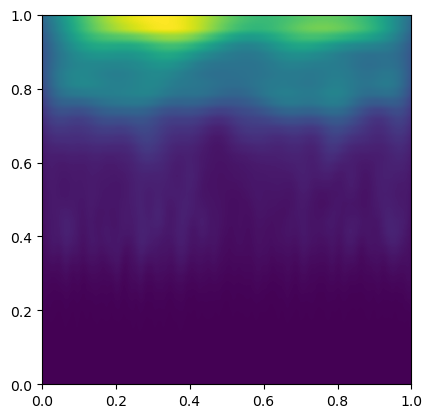

In [294]:
# plt.imshow(TFR[0,:,:], extent=[0, 1, 0, 1])
plt.imshow(TFR[:,:,:].mean(axis=0), extent=[0, 1, 0, 1])
# plt.imshow(TFR[:,:,:].mean(axis=1), extent=[0, 1, 0, 1])
# plt.imshow(TFR[:,:,:].mean(axis=2), extent=[0, 1, 0, 1])

In [284]:
eegsignal

Series([], Name: rhplt3-rhplt4, dtype: float64)

Here we are mostly going to make a lot of spectral plots and things to look over manually as a function of event timing, without getting into the more advanced GLM stuff. 

In [555]:
combined_df[combined_df.participant==subj_id].sort_values(by=['trials_mem']).dropna(subset=['trials_gamble']).reset_index(drop=True).condition




0     Day2
1     Day1
2     Day2
3     Day1
4     Day2
      ... 
75    Day2
76    Day1
77    Day2
78    Day1
79    Day2
Name: condition, Length: 80, dtype: object

In [595]:
# Load the data 
evs = ['recog_time']
epochs_all_subjs_all_evs = {f'{a}': {f'{b}': np.nan for b in evs} for a in subj_ids}

for subj_id in subj_ids:
    for day in ['Day2']:
        subj_df = combined_df[(combined_df.participant==subj_id) & (combined_df.condition==day)].sort_values(by=['trials_mem']).dropna(subset=['trials_gamble']).reset_index(drop=True)
        for event in evs:
            load_path = f'{base_dir}/work/qasims01/MemoryBanditData/EMU/Subjects/{subj_id}/neural/{day}/epoch_{event}.fif'
            epochs = mne.read_epochs(f'{load_path}', preload=True)
            epochs_all_subjs_all_evs[subj_id][event] = epochs

            # Let's add our behavioral events to the metadata. Substitute this with the particulars for your behavioral dataframe. 

            ied_data = epochs_all_subjs_all_evs[subj_id][event].metadata.copy()


            event_metadata = pd.concat([subj_df, ied_data], axis=1)


            epochs_all_subjs_all_evs[subj_id][event].metadata = event_metadata


/tmp/ipykernel_274249/1059601312.py:10: RuntimeWarning: This filename (/sc/arion/work/qasims01/MemoryBanditData/EMU/Subjects/MS015/neural/Day2/epoch_recog_time.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(f'{load_path}', preload=True)
/tmp/ipykernel_274249/1059601312.py:10: RuntimeWarning: This filename (/sc/arion/work/qasims01/MemoryBanditData/EMU/Subjects/MS016/neural/Day2/epoch_recog_time.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(f'{load_path}', preload=True)
/tmp/ipykernel_274249/1059601312.py:10: RuntimeWarning: This filename (/sc/arion/work/qasims01/MemoryBanditData/EMU/Subjects/MS017/neural/Day2/epoch_recog_time.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read

Plot and examine the epochs if you'd like

In [73]:
# %matplotlib notebook
# fig = epochs_all_subjs_all_evs['MS007']['feedback_start'].plot(n_epochs=10, n_channels=10)

In [74]:
# # Need this following line to save the annotations to the epochs object 
# fig.fake_keypress('a')

## Power spectrum (FOOOF)

Here, we are going to plot the group-level FOOOF analysis for two conditions in the task across all channels, and then also plot the individual power spectrums for each channel with model fit for each of the two conditions. Note the time specification to make sure I leave out the baseline period... 

FOOOF's primary utility, imo, is not in peak parameterization but 1/f subtraction. Peak parameters are subject to over- and under-fitting, and fit quality has too strong of an effect. Simply contrasting *n* PSDs (for *n* conditions) after removing the 1/f is a more healthy approach.

Goals: 
- Plot the FOOOF results 
- Collect the FOOOF parameters 
- Subtract the 1/f 
- Save/return the corrected PSDs (and overlay plot them) 


In [563]:
# Code to specify how to deal with roi inputs:
epochs.metadata.rpe_gamble


0    -0.192010
1    -0.957676
2    -0.978462
3     0.812608
4    -0.122541
5     0.063730
6     0.111722
7    -0.562806
8    -0.500000
9     0.823267
10   -0.010373
11    0.219538
12   -0.638524
13    0.254448
14    0.829855
15    0.007151
16    0.267487
17    0.192402
18   -0.597942
19    0.500000
20    0.009176
21   -0.262541
22   -0.022224
23   -0.993138
24    0.420492
25   -0.402511
26    0.246893
27    0.015628
28    0.431959
29    0.035594
30   -0.995971
31    0.609206
32    0.047598
33    0.084479
34   -0.050615
35    0.184628
36    0.915693
37   -0.436062
38   -0.279090
39    0.995716
Name: rpe_gamble, dtype: float64

In [564]:
evs

['recog_time']

In [596]:
tmin = -1.5
tmax = 0

# Define peak_width, peak_height, peak_threshold, max_n_peaks
FOOOF_kwargs = {'peak_width_limits': [1, 8], 
               'min_peak_height': 0.1,
                'peak_threshold': 1.,
                'max_n_peaks': 6,
               'freq_range': [1, 30]}
 
# Define our frequency bands of interest
band_dict = {'delta' : [1, 4],
               'theta' : [4, 8],
               'alpha' : [8, 13],
               'beta' : [13, 30]}


# Use the metadata to parse the epochs before computing anything

rois = ['hippocampus', 'parahippocampal' ,'frontal']
conditions = ["(rpe_gamble>0)&(hits==1)",
             "(rpe_gamble<0)&(hits==1)",
             "(rpe_gamble>0)&(hits==0)", 
             "(rpe_gamble<0)&(hits==0)"]
cond_name = 'rpe_mem_recall_intx'
#               "(reward_gamble==1)&(condition=='day_2')&(hits==0)",
# "(reward_gamble==1)&(condition=='day_2')&(hits==1)"

group_rois = False 
compare_dfs = []

for subj_id in subj_ids:
    # Get electrode df 
    elec_path = f'{base_dir}/projects/guLab/Salman/EMU/{subj_id}/anat/'
        # electrode files could either be csv or excel
    elec_files = glob.glob(f'{elec_path}/*.csv') + glob.glob(f'{elec_path}/*.xlsx')
    # There should really only be one 
    elec_file = elec_files[0]
    save_path = f'{base_dir}/work/qasims01/MemoryBanditData/EMU/Subjects/{subj_id}'
    
    # Load electrode data (should already be manually localized!)
    if elec_file.split('.')[-1] =='csv':
        elec_data = pd.read_csv(elec_file)
    elif elec_file.split('.')[-1] =='xlsx': 
        elec_data = pd.read_excel(elec_file)

    # Sometimes there's extra columns with no entries: 
    elec_data = elec_data[elec_data.columns.drop(list(elec_data.filter(regex='Unnamed')))]

    anode_list = [x.split('-')[0] for x in epochs_all_subjs_all_evs[subj_id][event].ch_names]
    elec_df = elec_data[elec_data.label.str.lower().isin(anode_list)]
    elec_df['label'] = epochs_all_subjs_all_evs[subj_id][event].ch_names

    for event in evs:    
        filepath = f'{base_dir}/work/qasims01/MemoryBanditData/EMU/Subjects/{subj_id}/scratch/FOOOF/{event}/{cond_name}'
        for region in rois: 
            
            file_path = f'{filepath}/{region}'    
            
            # sub-select channels and make directories if need be 
            picks = analysis_utils.select_picks_rois(elec_df, region)
            
            epochs_all_subjs_all_evs[subj_id][event].metadata['region'] = region
        
            # sub-select epochs 
            chan_epochs = epochs_all_subjs_all_evs[subj_id][event].copy().pick_channels(picks)

            compare_df = analysis_utils.FOOOF_compare_epochs(chan_epochs, tmin=tmin, tmax=tmax, 
                                              conditions=conditions, band_dict=band_dict, 
                                              file_path=file_path, plot=True, **FOOOF_kwargs)
            compare_dfs.append(compare_df)


/tmp/ipykernel_274249/206705331.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  elec_df['label'] = epochs_all_subjs_all_evs[subj_id][event].ch_names
/tmp/ipykernel_274249/206705331.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  elec_df['label'] = epochs_all_subjs_all_evs[subj_id][event].ch_names
/tmp/ipykernel_274249/206705331.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

In [597]:
all_dfs = pd.concat(compare_dfs)

/tmp/ipykernel_274249/669170714.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 68)` for the same effect.

  sns.barplot(data=all_dfs, x='region', y='exp_diff', ci=68)


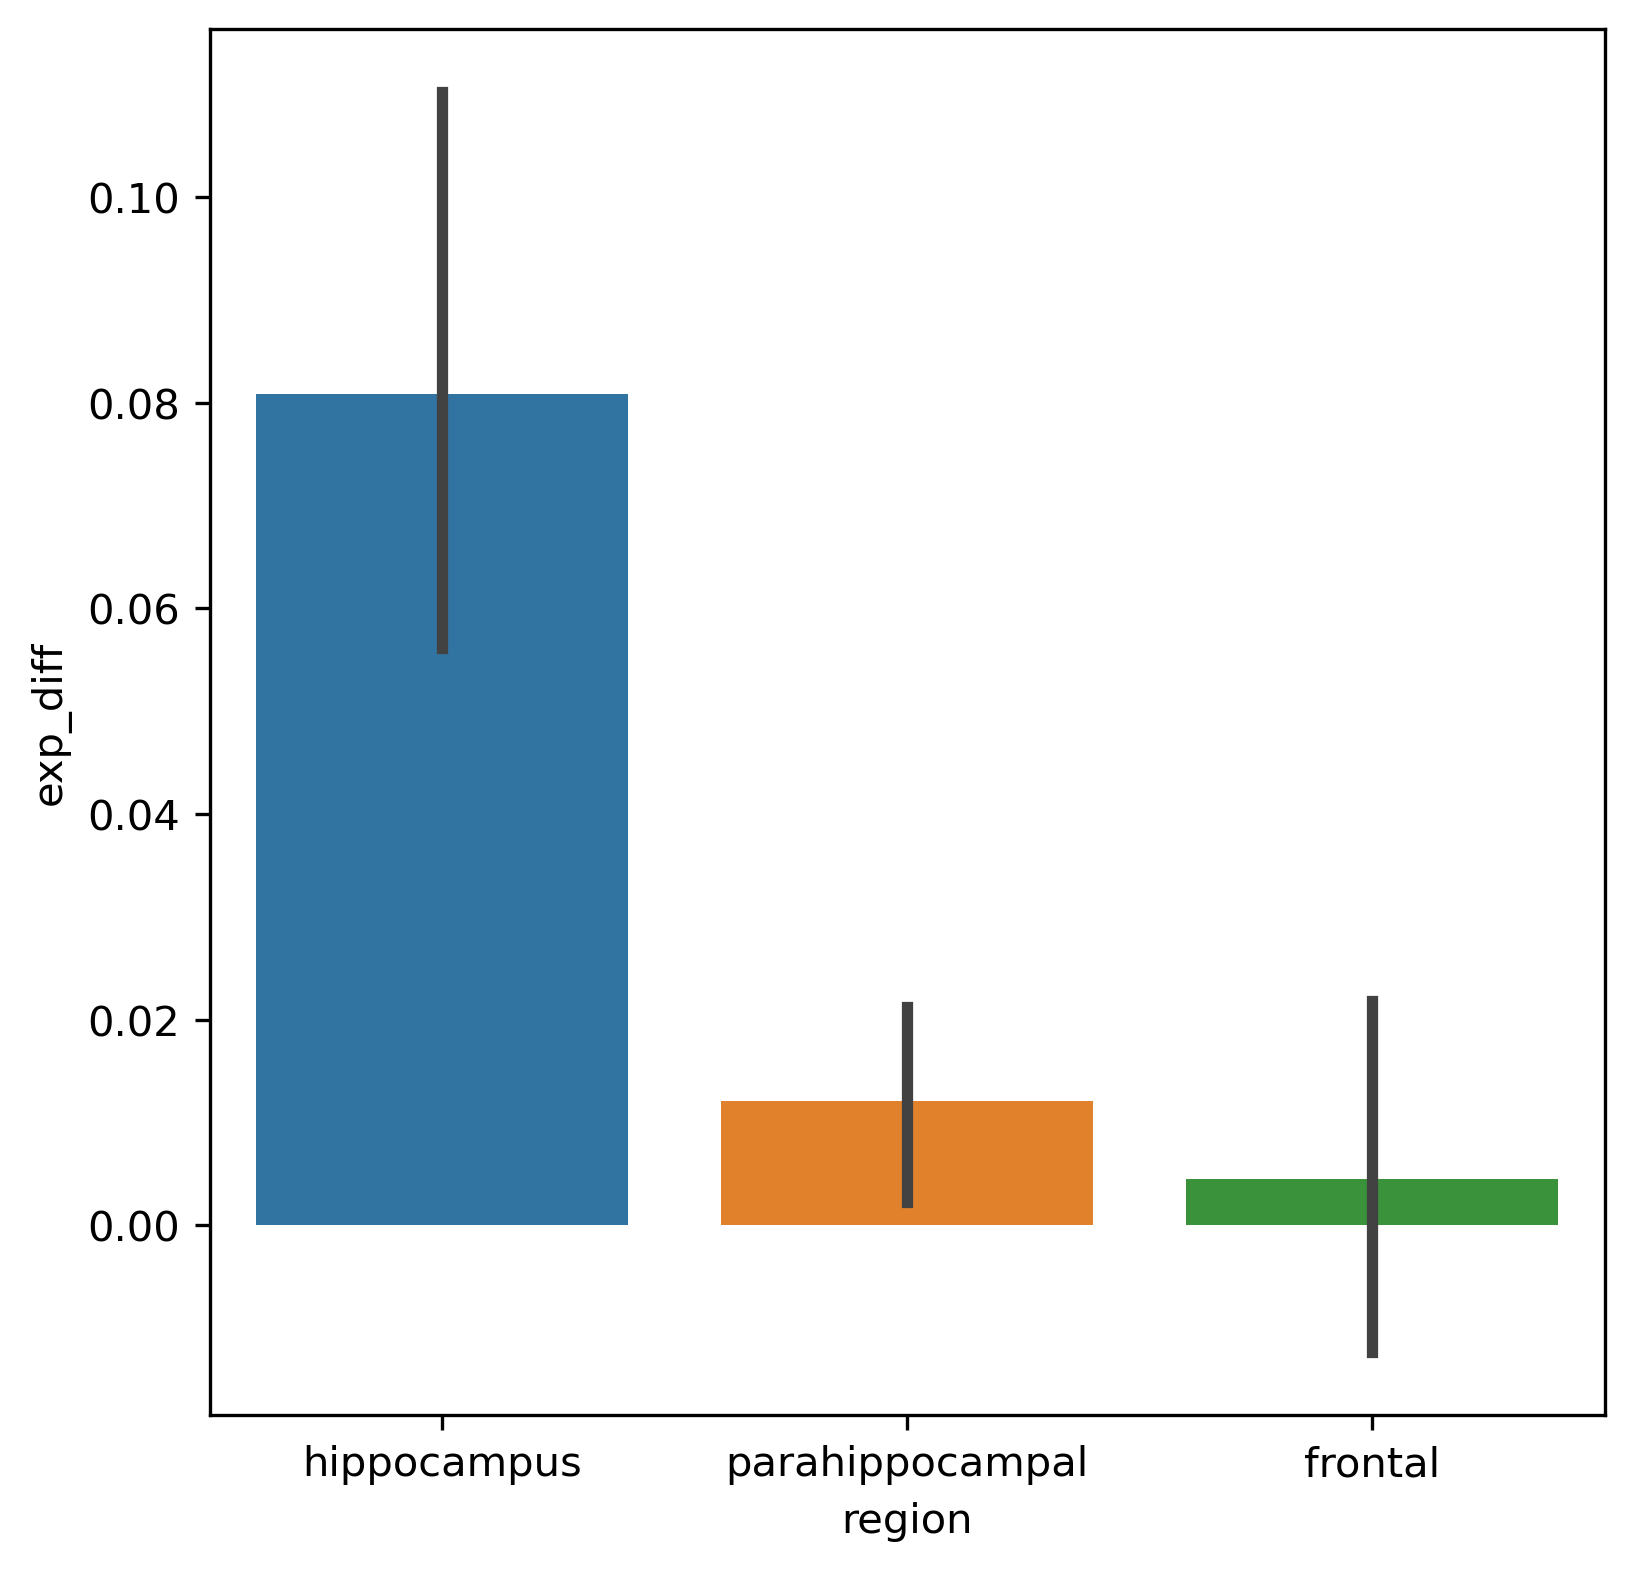

In [598]:
with PdfPages('/sc/arion/work/qasims01/MemoryBanditData/EMU/exponent_rpe_remembered_recall_day2.pdf') as pdf:
    f, ax = plt.subplots(1, 1, figsize=[6, 6], dpi=300)
    sns.barplot(data=all_dfs, x='region', y='exp_diff', ci=68)
    pdf.savefig()

/tmp/ipykernel_274249/2533977462.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 68)` for the same effect.

  sns.barplot(data=all_dfs, x='region', y='band_pow_diff', hue='band', ci=68, ax=ax)


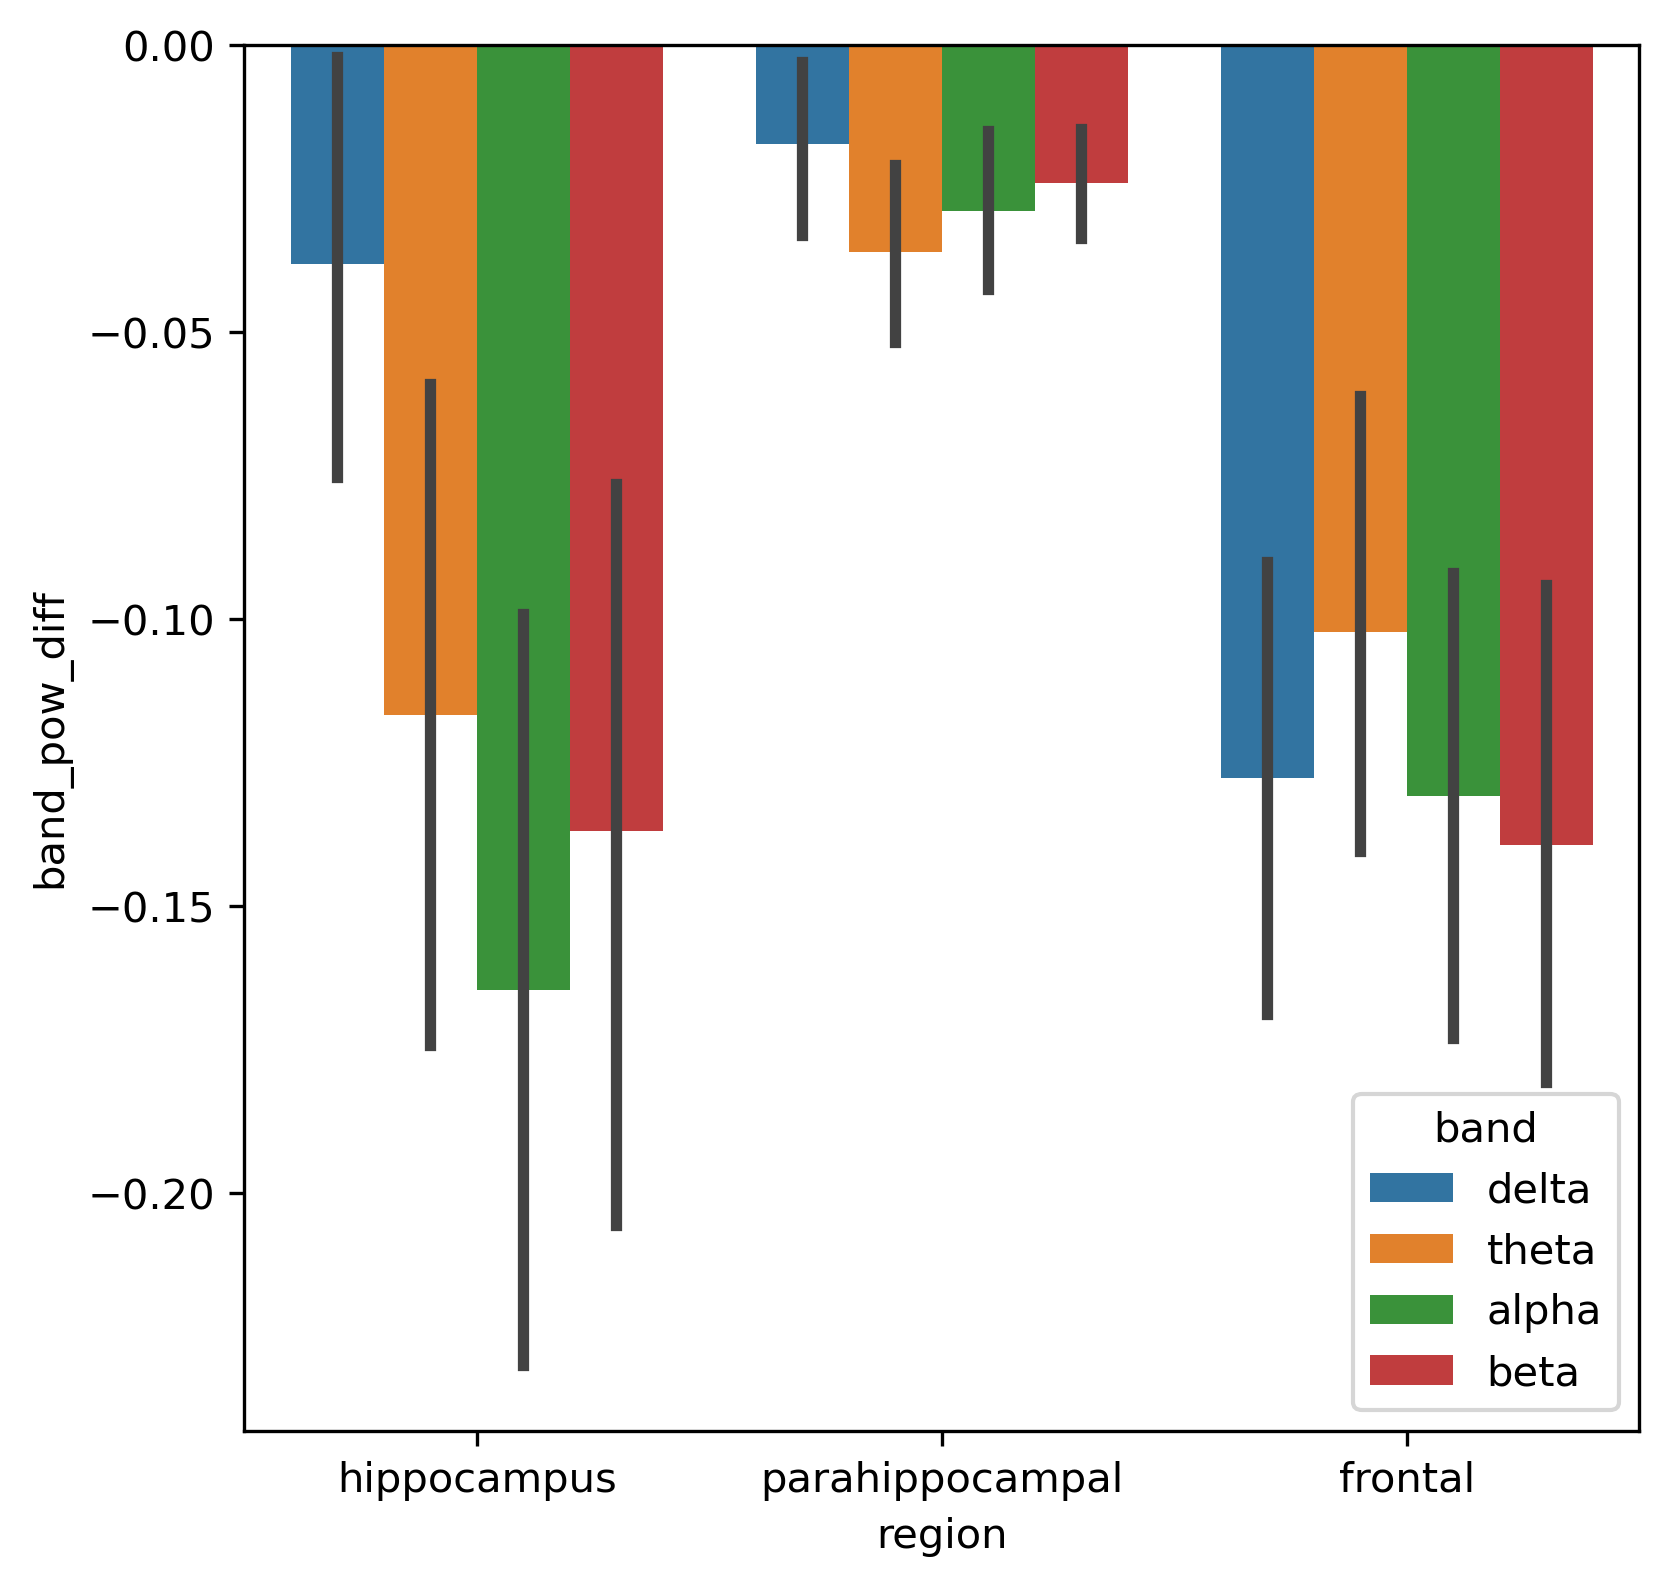

In [599]:
with PdfPages('/sc/arion/work/qasims01/MemoryBanditData/EMU/bandpow_rpe_remembered_recall_day2.pdf') as pdf:
    f, ax = plt.subplots(1, 1, figsize=[6, 6], dpi=300)
    sns.barplot(data=all_dfs, x='region', y='band_pow_diff', hue='band', ci=68, ax=ax)
    pdf.savefig()

For guidance on picking the parameters used to fit: https://fooof-tools.github.io/fooof/auto_tutorials/plot_07-TroubleShooting.html#sphx-glr-auto-tutorials-plot-07-troubleshooting-py

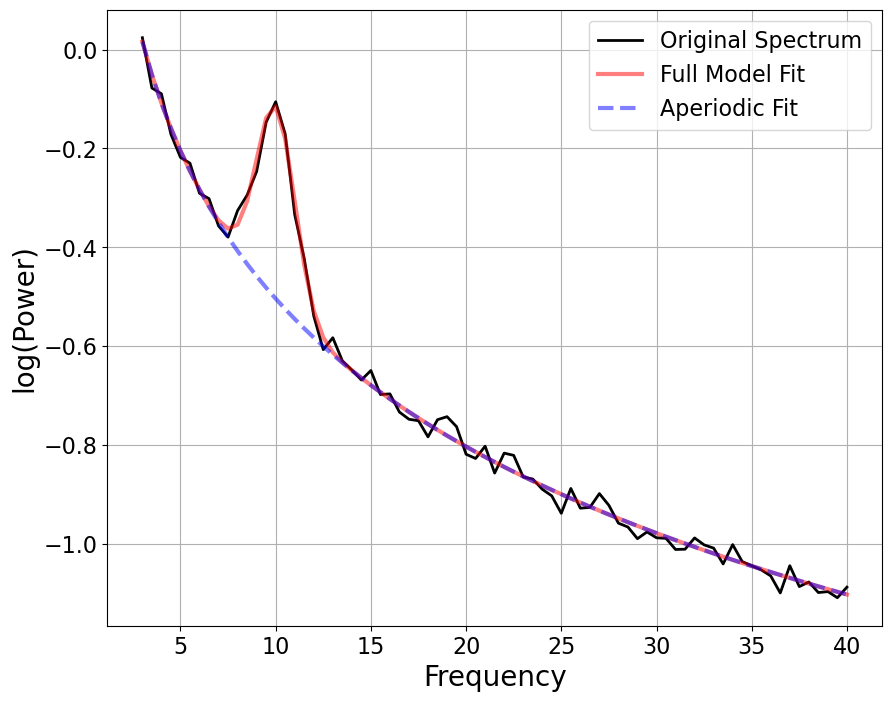

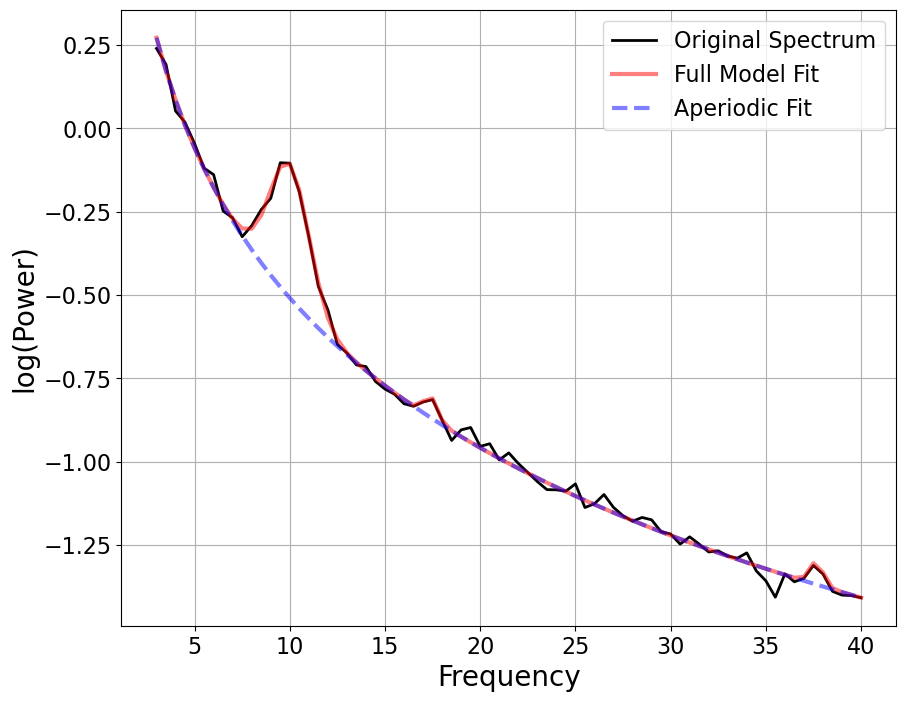

In [609]:
## Make a test figure of FOOOF 
# Import functions for creating simulated power spectra
from fooof.sim.gen import gen_power_spectrum, gen_group_power_spectra

# Import plotting functions
from fooof.plts.spectra import plot_spectrum, plot_spectra

# Import the FOOOF object
from fooof import FOOOF

# Create some new settings for simulating a group of power spectra
n_spectra = 2
freq_range = [3, 40]
nlv = 0.02

# Aperiodic params: define values for each spectrum, with length equal to n_spectra
aperiodic_params = [[0.5, 1], [1, 1.5]]

# Periodic parameters: define a single definition, to be applied to all spectra
periodic_params = [10, 0.4, 1]

# Simulate a group of power spectra
freqs, powers = gen_group_power_spectra(n_spectra, freq_range, aperiodic_params,
                                        periodic_params, nlv)

# Initialize a FOOOF object, and add some data to it
fm = FOOOF(verbose=False)
fm.add_data(freqs, powers[0])
# Fit the model, and plot the reconstruction
fm.fit()
fm.plot(save_fig=True, file_path='/sc/arion/work/qasims01/MemoryBanditData/EMU', file_name='sim_1.pdf')

fm = FOOOF(verbose=False)
fm.add_data(freqs, powers[1])
# Fit the model, and plot the reconstruction
fm.fit()
fm.plot(save_fig=True, file_path='/sc/arion/work/qasims01/MemoryBanditData/EMU', file_name='sim_2.pdf')


## Empirical mode decomposition for cycle/burst detection (WIP)

The benefit of EMD is that we get away from assumptions of sinuisoidal oscillations and linearity in the time-series. 

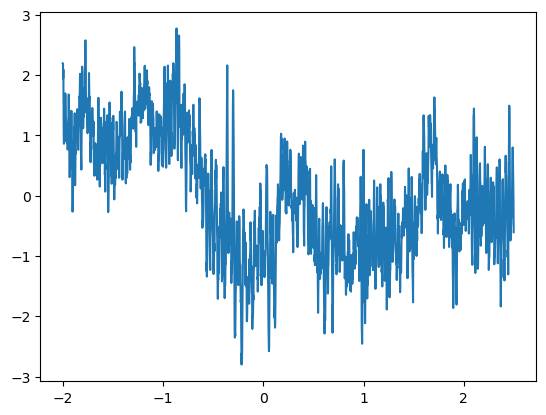

In [327]:
# Zscore the data first (idk why, but otherwise unable to plot IMFs) 

test_epoch = zscore(epochs_all_subjs_all_evs[subj_id][event]._data[0, 26, :])
time_vect = epochs_all_subjs_all_evs[subj_id][event].times
sample_rate = int(epochs_all_subjs_all_evs[subj_id][event].info['sfreq'])
plt.plot(time_vect, test_epoch)

<AxesSubplot:xlabel='Time (samples)'>

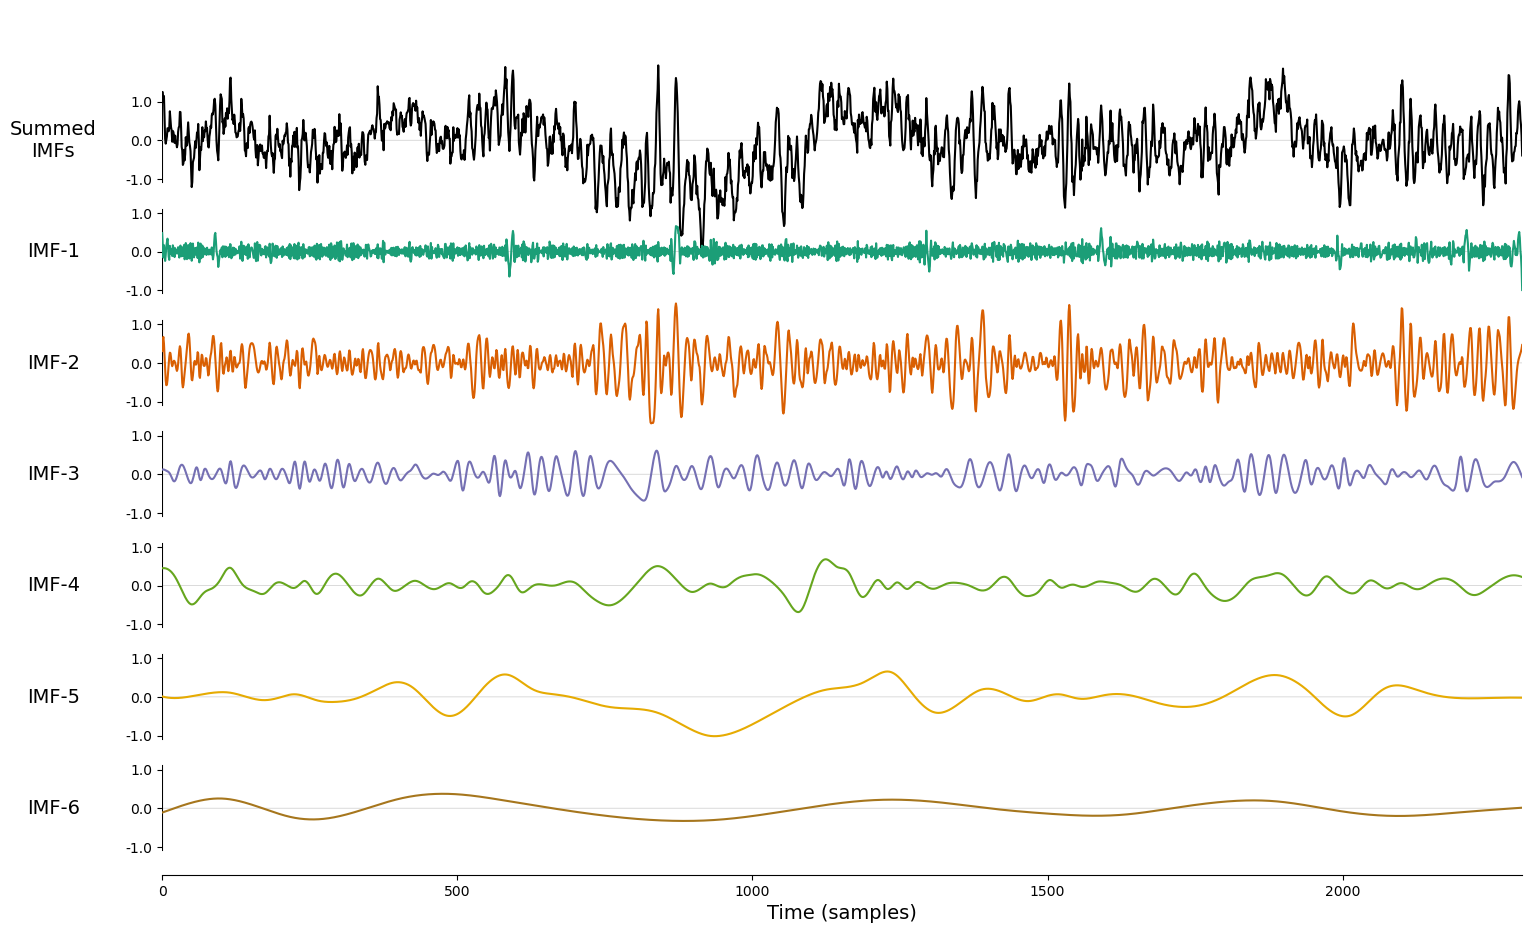

In [328]:
imf = emd.sift.sift(test_epoch, max_imfs=6)
# Visualise the IMFs
emd.plotting.plot_imfs(imf)

Here, it looks like IMF-2 might have some meaningful oscillatory bursts in it

from the IMFs, compute the instantaneous frequency, phase and amplitude using the Normalised Hilbert Transform Method

In [334]:
IP, IF, IA = emd.spectra.frequency_transform(imf, sample_rate, 'hilbert')
# Extract cycle locations
all_cycles = emd.cycles.get_cycle_vector(IP, return_good=False)
good_cycles = emd.cycles.get_cycle_vector(IP, return_good=True)

# ``all_cycles`` is an array of the same size as the input instantaneous phase.
# Each row contains a vector of itegers indexing the location of successive
# cycles for that IMF.

# Set a 33% amplitude threshold on IMF-1 

thresh = np.percentile(IA[:, 1], 33)
mask = IA[:, 1] > thresh

mask_cycles = emd.cycles.get_cycle_vector(IP, return_good=True, mask=mask)

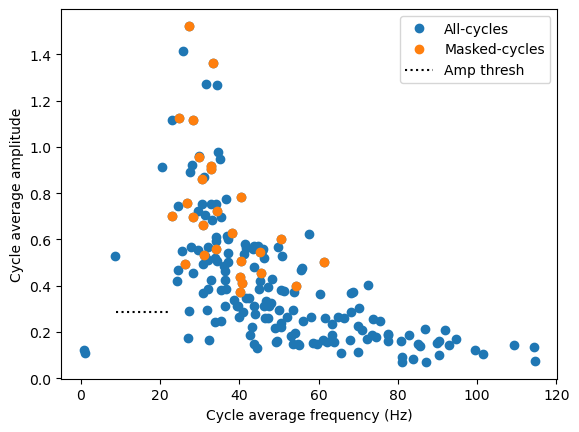

In [335]:

# Compute cycle average frequency for all cycles and masked cycles
all_cycle_freq = emd.cycles.get_cycle_stat(all_cycles[:, 1], IF[:, 1], func=np.mean)
mask_cycle_freq = emd.cycles.get_cycle_stat(mask_cycles[:, 1], IF[:, 1], func=np.mean)

# Compute cycle frequency range for all cycles and for masked cycles
all_cycle_amp = emd.cycles.get_cycle_stat(all_cycles[:, 1], IA[:, 1], func=np.mean)
mask_cycle_amp = emd.cycles.get_cycle_stat(mask_cycles[:, 1], IA[:, 1], func=np.mean)

# Make a summary figures
plt.figure()
plt.plot(all_cycle_freq, all_cycle_amp, 'o')
plt.plot(mask_cycle_freq, mask_cycle_amp, 'o')
plt.xlabel('Cycle average frequency (Hz)')
plt.ylabel('Cycle average amplitude')
plt.plot((9, 22), (thresh, thresh), 'k:')
plt.legend(['All-cycles', 'Masked-cycles', 'Amp thresh'])

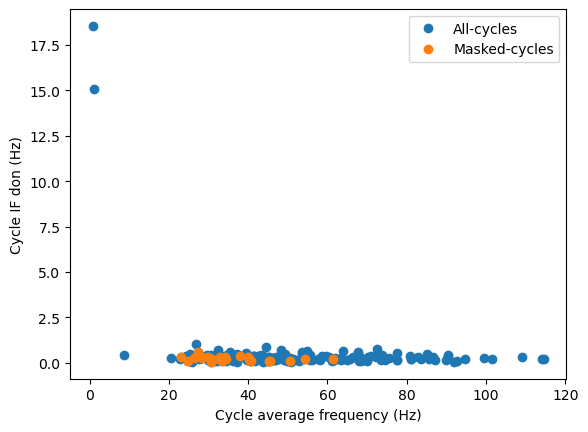

In [336]:
# Compute cycle average frequency for all cycles and masked cycles
all_cycle_freq = emd.cycles.get_cycle_stat(all_cycles[:, 1], IF[:, 1], func=np.mean)
mask_cycle_freq = emd.cycles.get_cycle_stat(mask_cycles[:, 1], IF[:, 1], func=np.mean)


# Define a simple function to compute the range of a set of values
def degree_nonlinearity(x):
    return np.std((x - x.mean()) / x.mean())


# Compute cycle freuquency range for all cycles and for masked cycles
all_cycle_freq_don = emd.cycles.get_cycle_stat(all_cycles[:, 1], IF[:, 1],
                                               func=degree_nonlinearity)
cycle_freq_don = emd.cycles.get_cycle_stat(mask_cycles[:, 1], IF[:, 1],
                                           func=degree_nonlinearity)

# Make a summary figures
plt.figure()
plt.plot(all_cycle_freq, all_cycle_freq_don, 'o')
plt.plot(mask_cycle_freq, cycle_freq_don, 'o')
plt.xlabel('Cycle average frequency (Hz)')
plt.ylabel('Cycle IF don (Hz)')
plt.legend(['All-cycles', 'Masked-cycles'])

In [337]:
C = emd.cycles.Cycles(IP[:, 1])


In [345]:
C.compute_cycle_metric('max_amp', IA[:, 1], func=np.max)
# Compute the length of each cycle
C.compute_cycle_metric('duration', IA[:, 1], len)


In [347]:
df = C.get_metric_dataframe()
print(df)

     is_good   max_amp  duration
0          0  0.712878        12
1          0  0.408407         7
2          0  0.340272         9
3          0  0.632888        12
4          0  0.762989        17
..       ...       ...       ...
183        1  1.036988        16
184        1  0.985259        17
185        0  1.232302        18
186        1  1.261188        18
187        0  0.631540         8

[188 rows x 3 columns]


(0.0, 60.0)

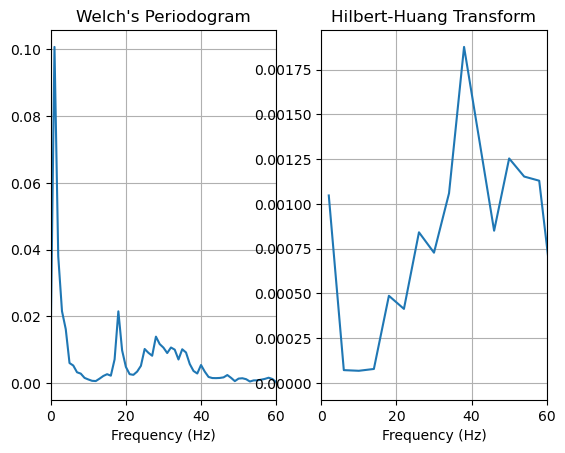

In [364]:
from scipy import signal 
fft_f, pxx_linear = signal.welch(test_epoch, fs=sample_rate, nperseg=512)

# Summary figure
plt.figure()
plt.subplot(121)
plt.plot(fft_f, pxx_linear)
plt.title("Welch's Periodogram")
# plt.xlim(0, 20)
# plt.xticks(np.arange(10)*2)
plt.grid(True)
plt.xlabel('Frequency (Hz)')

# Hilbert-Huang transform
freq_range = (0, 256, 64)
hht_f, spec_linear = emd.spectra.hilberthuang(IF, IA, freq_range, scaling='density', sum_imfs=False)

plt.xlim(0, 60)
plt.subplot(122)
plt.plot(hht_f, spec_linear[:, 0])
# plt.xticks(np.arange(10)*2)
plt.grid(True)
plt.title("Hilbert-Huang Transform")
plt.xlabel('Frequency (Hz)')
plt.xlim(0, 60)

In [355]:
fft_f.shape

(257,)

From the instantaneous frequency and amplitude, we can compute the Hilbert-Huang spectrum:



In [195]:
# Define frequency range (low_freq, high_freq, nsteps, spacing)
freq_range = (0.1, 30, 80, 'log')
f, hht = emd.spectra.hilberthuang(IF, IA, freq_range, sum_time=False)

<AxesSubplot:title={'center':'Hilbert-Huang Transform'}, xlabel='Time', ylabel='Frequency'>

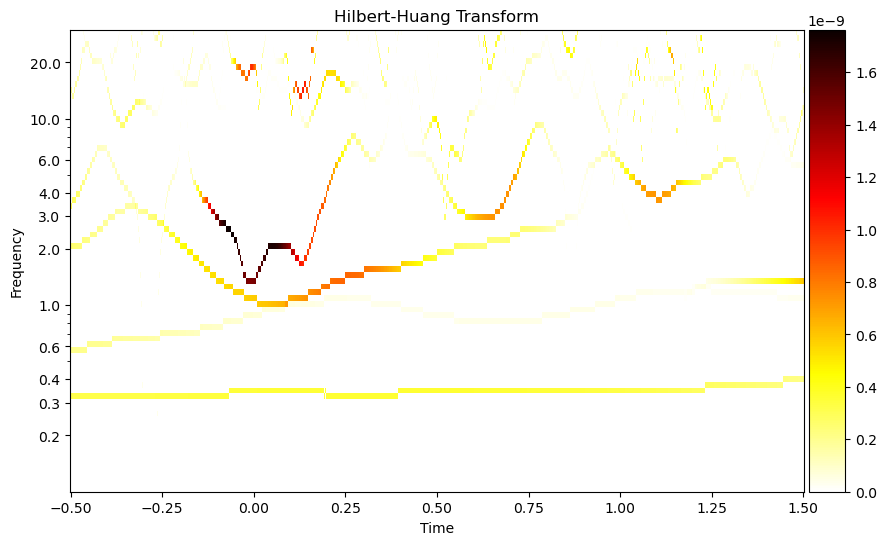

In [199]:
fig = plt.figure(figsize=(10, 6))
emd.plotting.plot_hilberthuang(hht, time_vect, f,
                               time_lims=(-0.5, 1.5), freq_lims=(0.1, 30),
                               fig=fig, log_y=True)

## Wavelet TFRs

Here, we will plot some basic TFRs of our behaviorally-locked analysis using a wavelet transform. We can also use these to compute the inter-trial phase coherence (ITC). 

Let's set some parameters first


Use the metadata to assign conditions to parse your epochs!

In [ ]:
# power parameters 
freqs = np.logspace(*np.log10([4, 128]), num=20)
n_cycles = 4  
sr = epochs_all_subjs_all_evs[subj_id][event].info['sfreq']
buf = 1.0
buf_ix = int(buf*sr)
      
data_parsing = ['reward==1',
                'reward==0']

for subj_id in subj_ids:
    for event in evs:
                
        diff_pow_epochs = {f'{x}':np.nan for x in data_parsing}
        diff_itc_epochs = {f'{x}':np.nan for x in data_parsing}

        epochs = epochs_all_subjs_all_evs[subj_id][event]
        
        good_chans = [x for x in epochs.ch_names if x not in epochs.info['bads']]
        picks = [x for x in good_chans]
        
        
        # baseline_pow = mne.time_frequency.tfr_morlet(baseline_epochs, picks=picks,
        #                                      freqs=freqs, n_cycles=n_cycles, use_fft=True,
        #                 return_itc=False, n_jobs=-1, average=False)

        # Compute power without averaging over events
        
        for parsing in data_parsing: 
            pow_struct = np.ones([epochs[parsing]._data.shape[0], 
                                   epochs[parsing]._data.shape[1], len(freqs), 
                                   epochs[parsing]._data.shape[-1]])
            itc_struct = np.ones([epochs[parsing]._data.shape[0], 
                                   epochs[parsing]._data.shape[1], len(freqs), 
                                   epochs[parsing]._data.shape[-1]])
            
            for ch_ix in np.arange(epochs._data.shape[1]): 
                ch_data = epochs[parsing]._data[:, ch_ix:ch_ix+1, :]
                bad_epochs  = np.where(epochs.metadata.query(parsing)[epochs.ch_names[ch_ix]].notnull())[0]
        #         print(len(bad_epochs))
                good_epochs = np.delete(np.arange(ch_data.shape[0]), bad_epochs)
                ch_data = np.delete(ch_data, bad_epochs, axis=0)
                ch_pow, ch_itc = mne.time_frequency.tfr_array_morlet(ch_data, sfreq=epochs.info['sfreq'], 
                                                    freqs=freqs, n_cycles=n_cycles, zero_mean=True, 
                                                    use_fft=True, output='power', return_itc=True,
                                                    n_jobs=1)

                pow_struct[good_epochs, ch_ix, :, :] = ch_pow[:, 0, :, :]
                itc_struct[good_epochs, ch_ix, :, :] = ch_itc[:, 0, :, :]
                
            temp_pow = mne.time_frequency.EpochsTFR(epochs[parsing].info, pow_struct, 
                                                    epochs.times, freqs)
            temp_itc = mne.time_frequency.EpochsTFR(epochs[parsing].info, itc_struct, 
                                                    epochs.times, freqs)

        #     temp_pow = mne.time_frequency.tfr_morlet(epochs[parsing], picks=picks,
        #                                              freqs=freqs, n_cycles=n_cycles, use_fft=True,
        #                         return_itc=False, n_jobs=-1, average=False)
            # Baseline correct the TFRs
            temp_pow = temp_pow.apply_baseline(baseline=(-feedback_pre, 0), mode='zscore')
        #     baseline_pow.crop(tmin=-baseline_pre, tmax=baseline_post)
        #     temp_pow.data = lfp_preprocess_utils.zscore_TFR_across_trials(temp_pow.data, baseline_pow.data)
            temp_pow.crop(tmin=-feedback_pre, tmax=feedback_post)
            temp_itc.crop(tmin=-feedback_pre, tmax=feedback_post)
            diff_pow_epochs[parsing] = temp_pow
            diff_itc_epochs[parsing] = temp_itc
            
            
            # Make some plots 
            # TODO
            
            # Save out the data 
            # TODO 
            

## Statistical Analyses of TFRs:

At this stage, you should **heavily** brainstorm the statistics you want to do, before you start writing any code. What is the goal of your analysis? What would actually allow you to show what you want to show?

As an example, let's say I want to compare the reward vs. no-reward conditions for every channel, and identify the timepoints and frequencies that exhibit significant differences between conditions. To do so, I would utilize a non-parametric cluster-permutation test.

In [ ]:
for label in diff_pow_epochs[parsing].ch_names[0:1]: 
    region_label = elec_df[elec_df.label==label].YBA_1.values[0]
    if region_label == 'Unknown':
        region_label = elec_df[elec_df.label==label]['Manual Examination'].values[0]

    plot_ix = diff_pow_epochs[parsing].ch_names.index(label)
    
    rdata = diff_pow_epochs['reward==1'].data[:, plot_ix, :, :]
    nrdata = diff_pow_epochs['reward==0'].data[:, plot_ix, :, :]

for label in diff_pow_epochs[parsing].ch_names: 
    region_label = elec_df[elec_df.label==label].YBA_1.values[0]
    if region_label == 'Unknown':
        region_label = elec_df[elec_df.label==label]['Manual Examination'].values[0]

    plot_ix = diff_pow_epochs[parsing].ch_names.index(label)
    
    rdata = diff_pow_epochs['reward==1'].data[:, plot_ix, :, :]
    rdata = rdata[np.unique(np.where(~np.isnan(rdata))[0]), :, :]
    nrdata = diff_pow_epochs['reward==0'].data[:, plot_ix, :, :]
    nrdata = nrdata[np.unique(np.where(~np.isnan(nrdata))[0]), :, :]
        
    X = [rdata, 
         nrdata]
    
    F_obs, clusters, cluster_p_values, H0 = \
    mne.stats.permutation_cluster_test(X, n_permutations=1000, out_type='mask', 
                                       verbose=True)
    
    if any(cluster_p_values<=0.05):
        print(region_label)
        # Create new stats image with only significant clusters
        fig, ax = plt.subplots(1, 1, figsize=(6, 4))

        times = diff_pow_epochs['reward==0'].times

        evoked_power_1 = np.nanmean(X[0], axis=0)
        evoked_power_2 = np.nanmean(X[1], axis=0)
        evoked_power_contrast = evoked_power_1 - evoked_power_2
        signs = np.sign(evoked_power_contrast)

        F_obs_plot = np.nan * np.ones_like(F_obs)
        for c, p_val in zip(clusters, cluster_p_values):
            if p_val <= 0.05:
                F_obs_plot[c] = F_obs[c] * signs[c]

        ax.imshow(F_obs,
                  extent=[times[0], times[-1], freqs[0], freqs[-1]],
                  aspect='auto', origin='lower', cmap='gray')
        max_F = np.nanmax(abs(F_obs_plot))
        ax.imshow(F_obs_plot,
                  extent=[times[0], times[-1], freqs[0], freqs[-1]],
                  aspect='auto', origin='lower', cmap='RdBu_r',
                  vmin=-max_F, vmax=max_F)

        ax.set_xlabel('Time (ms)')
        ax.set_ylabel('Frequency (Hz)')
        # # ax.set_title(f'Induced power ({ch_name})')
    
    